In [1]:
%cd "~/projects/spartDM"
%load_ext autoreload
%autoreload 2

import os

print(f"Current working dir: {os.getcwd()}")

import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import torch
import torch.nn as nn
from einops import rearrange

from src.ldae import TADMLitModel
import yaml

/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/kdang/projects/spartDM
Current working dir: /home/kdang/projects/spartDM


/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/generative/networks/layers/vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/generative/networks/layers/vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


## Helper functions

In [2]:
import torchvision

# Helper function to quick plot a tensor using torchvision grid
def quick_plot_tensor(x, title, normalize=True):
    """
    x: torch.tensor of size(B, C, H, W)
    """
    if isinstance(x, np.ndarray):
        x = torch.tensor(x, dtype=torch.float32)
    grid = torchvision.utils.make_grid(x, nrow=10, normalize=normalize, padding=1)  # noqa: F821
    plt.figure(figsize=(16, 4))  
    plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.title(title)
    plt.axis("off")

from src.utils.visualization import plot_comparison_starmen

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loader

In [4]:
from src.data.datamodules import StarmenDataset
from monai.data import DataLoader
from monai.data.utils import first

# train_ds = StarmenDataset(
#     data_dir="data/starmen/output_random_noacc",
#     split="train",
#     nb_subject=None,
# )

# train_loader = DataLoader(train_ds, batch_size=20, shuffle=True, num_workers=1)
# one_batch = first(iter(train_loader))

test_ds = StarmenDataset(
    data_dir="data/starmen/output_random_noacc",
    split="test",
    nb_subject=None,
)

growing_circle_ds = StarmenDataset(
    data_dir="data/starmen/output_random_noacc",
    split="growing_circle20",
    nb_subject=None,
)



test_loader = DataLoader(test_ds, batch_size=1, shuffle=True, num_workers=1)

growing_circle_loader = DataLoader(growing_circle_ds, batch_size=1, shuffle=True, num_workers=1)

# Load conDDPM model


In [5]:
# Load model

# CondDDPM model

from src.ldae import CondDDPM
from lightning.pytorch.utilities.model_summary import ModelSummary


WORK_DIR = "workdir/diffae_starmen"
# WORK_DIR = "workdir/debug"

## Load model
ckpt_path = os.path.join(WORK_DIR, "representation-learning", "checkpoints", "best.ckpt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

diffae_litmodel = CondDDPM.load_from_checkpoint(ckpt_path, map_location=device)
encoder = diffae_litmodel.ema_encoder
encoder.eval()
ema_decoder = diffae_litmodel.ema_decoder
ema_decoder.eval()
gaussian_diffusion = diffae_litmodel.gaussian_diffusion

# Model summary

summary = ModelSummary(diffae_litmodel, max_depth=1)
print(summary)

Backbone model loaded successfully.
Frozen first 0 layers out of 161 in the backbone

  | Name        | Type            | Params | Mode 
--------------------------------------------------------
0 | decoder     | CondUNet        | 2.5 M  | train
1 | encoder     | SemanticEncoder | 24.6 M | train
2 | ema_encoder | SemanticEncoder | 24.6 M | eval 
3 | ema_decoder | CondUNet        | 2.5 M  | eval 
--------------------------------------------------------
27.1 M    Trainable params
27.1 M    Non-trainable params
54.1 M    Total params
216.547   Total estimated model params size (MB)
492       Modules in train mode
492       Modules in eval mode


# TADM model

## Test Init from litmodel

In [6]:
from src.ldae import TADMLitModel
import yaml

with open("configs/starmen_tadm.yaml", "r") as file:
    args = yaml.safe_load(file)


tadm_args = args["test"]["model"]["init_args"]
tadm_args["test_ddim_style"] = "ddim1"
tadm_args

{'spartial_dim': 2,
 'mode': 'tadm',
 'args': {'sr_scale': 1,
  'use_attn': False,
  'res': True,
  'up_input': False,
  'use_wn': False,
  'weight_init': False,
  'use_rrdb': True,
  'fix_rrdb': False,
  'rrdb_num_block': 8,
  'rrdb_num_feat': 64},
 'timesteps_args': {'timesteps': 1000, 'betas_type': 'linear'},
 'lr': 2.5e-05,
 'ema_decay': 0.999,
 'ema_update_after_step': 10,
 'log_img_every_epoch': 10,
 'test_ddim_style': 'ddim1',
 'test_noise_level': 250}

In [34]:

tadm_litmodel = TADMLitModel(**tadm_args)
encoder = tadm_litmodel.encoder
encoder
decoder = tadm_litmodel.decoder
decoder

TADMUnet(
  (cond_proj): ConvTranspose2d(192, 32, kernel_size=(1, 1), stride=(1, 1))
  (time_pos_emb): SinusoidalPosEmb()
  (mlp): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): Mish()
    (2): Linear(in_features=128, out_features=32, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): ResnetBlock(
        (mlp): Sequential(
          (0): Mish()
          (1): Linear(in_features=32, out_features=32, bias=True)
        )
        (mlp_diff_ages): Sequential(
          (0): Mish()
          (1): Linear(in_features=32, out_features=32, bias=True)
        )
        (mlp_age): Sequential(
          (0): Mish()
          (1): Linear(in_features=32, out_features=32, bias=True)
        )
        (mlp_patient_condition): Sequential(
          (0): Mish()
          (1): Linear(in_features=64, out_features=32, bias=True)
        )
        (block1): Block(
          (block): Sequential(
            (0): ReflectionPad2d((1, 1, 1, 1))
            

## Normal init

In [3]:
from src.tadm.models.unet import TADMUnet, RRDBNet


import argparse

hparams = argparse.Namespace(
    rrdb_num_block=True,
    sr_scale=1, 
)

hparams = {
   "sr_scale":1,
   "use_attn": False, 
   "res": True,
   "up_input": False,
   "use_wn": False,
   "weight_init": False,
    "use_rrdb": True,
    "fix_rrdb": False, 
    "rrdb_num_block": 8,
    "rrdb_num_feat": 64,
    "rrdb_ckpt": '',
}


tadm_unet = TADMUnet(dim=32, out_dim=1, dim_mults=(1, 2, 2, 4), cond_dim=hparams['rrdb_num_feat'], hparams=hparams)
tadm_unet.downs[0]

if hparams['use_rrdb']:
    rrdb_net = RRDBNet(1, 1, hparams['rrdb_num_feat'], hparams['rrdb_num_block'],
                    hparams['rrdb_num_feat'] // 2, hparams=hparams)


In [4]:
print(type(tadm_unet.downs))
for i, mod in tadm_unet.downs.named_children():
    mod_list = []
    for idx, module in enumerate(mod):
        mod_list.append(module.__class__.__name__)
    print(f"{i}: {type(mod)} - {mod_list}")

# check the dim
dim =  32
dim_mults = [1, 2, 2, 4]
dims = [1, *map(lambda m: dim * m, dim_mults)]
print(dims)

test = tadm_unet.downs[1]
test

<class 'torch.nn.modules.container.ModuleList'>
0: <class 'torch.nn.modules.container.ModuleList'> - ['ResnetBlock', 'ResnetBlock', 'Downsample']
1: <class 'torch.nn.modules.container.ModuleList'> - ['ResnetBlock', 'ResnetBlock', 'Downsample']
2: <class 'torch.nn.modules.container.ModuleList'> - ['ResnetBlock', 'ResnetBlock', 'Downsample']
3: <class 'torch.nn.modules.container.ModuleList'> - ['ResnetBlock', 'ResnetBlock', 'Identity']
[1, 32, 64, 64, 128]


ModuleList(
  (0): ResnetBlock(
    (mlp): Sequential(
      (0): Mish()
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
    (mlp_diff_ages): Sequential(
      (0): Mish()
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
    (mlp_age): Sequential(
      (0): Mish()
      (1): Linear(in_features=32, out_features=64, bias=True)
    )
    (mlp_patient_condition): Sequential(
      (0): Mish()
      (1): Linear(in_features=64, out_features=64, bias=True)
    )
    (block1): Block(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        (2): Mish()
      )
    )
    (block2): Block(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (2): Mish()
      )
    )
    (res_conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (1): ResnetBlock(
    (mlp): Sequential(
      (0): 

## Load pretrained model

In [7]:
from lightning.pytorch.utilities.model_summary import ModelSummary


ckpt_path = "workdir/diffae_starmen/tadm/checkpoints/best.ckpt"

ckpt = torch.load(ckpt_path, map_location=torch.device("cpu"))
ckpt

tadm_litmodel = TADMLitModel.load_from_checkpoint(ckpt_path, map_location=device)

print(ModelSummary(tadm_litmodel, max_depth=1))

  | Name        | Type     | Params | Mode 
-------------------------------------------------
0 | encoder     | RRDBNet  | 5.9 M  | train
1 | decoder     | TADMUnet | 2.4 M  | train
2 | ema_encoder | RRDBNet  | 5.9 M  | eval 
3 | ema_decoder | TADMUnet | 2.4 M  | eval 
-------------------------------------------------
8.3 M     Trainable params
8.3 M     Non-trainable params
16.6 M    Total params
66.462    Total estimated model params size (MB)
614       Modules in train mode
614       Modules in eval mode


In [8]:
# diff age - age
b, t, c, h, w = 2, 10, 1, 64, 64
emb_dim = 512
dm_age = torch.randn(t)

dm_age_emb = tadm_unet.time_pos_emb(dm_age)
dm_age_emb.shape

x =torch.randn(t, 3, h, w)
img_lr = torch.randn(t, c, h, w)
img_hr = torch.randn(t, c, h, w)

NameError: name 'tadm_unet' is not defined

In [144]:
# Extract feature with RRDB Net

rrdb_net.eval()
with torch.no_grad():
    rrdb_out, cond = rrdb_net(img_lr, True)

print(f"rrdb_out: {rrdb_out.shape}")
print(f"cond: {len(cond)}")

for i, c in enumerate(cond):
    print(f"cond [{i}]: {c.shape}")

# cond = tadm_unet.cond_proj(torch.cat(cond[2::3], 1))
# cond.shape

rrdb_out: torch.Size([10, 1, 64, 64])
cond: 9
cond [0]: torch.Size([10, 64, 64, 64])
cond [1]: torch.Size([10, 64, 64, 64])
cond [2]: torch.Size([10, 64, 64, 64])
cond [3]: torch.Size([10, 64, 64, 64])
cond [4]: torch.Size([10, 64, 64, 64])
cond [5]: torch.Size([10, 64, 64, 64])
cond [6]: torch.Size([10, 64, 64, 64])
cond [7]: torch.Size([10, 64, 64, 64])
cond [8]: torch.Size([10, 64, 64, 64])


In [147]:
# cond = torch.randn(t, 3, h ,w)
time = torch.randn(t)
time_emb = tadm_unet.time_pos_emb(time)
time_emb = tadm_unet.mlp(time_emb)

x = img_hr - img_lr
x_noise = x + torch.randn_like(x)

noise_pred = tadm_unet(x=x_noise, 
                       time=time, 
                       cond=cond, 
                       img_lr_up=img_lr, 
                       diff_ages=dm_age, 
                       age=dm_age)


noise_pred.shape

torch.Size([10, 1, 64, 64])

## Train 1 batch 


## Select pair of current and previous scan

In [10]:
img_lr = one_batch["x_origin"][:, :-1, ...]
print(img_lr.shape)

img_hr = one_batch["x_origin"][:, 1:, ...]
print(img_hr.shape)

# sanity check
check = img_hr[:, :-1, ...] == img_lr[:, 1:, ...]
torch.all(check)

# Get the age of prior images
ages = one_batch["age"][:, :-1, ...]
ages.shape

diff_ages = torch.diff(one_batch["age"])
diff_ages.shape

## sanity check
print(one_batch["age"][0])
print(diff_ages[0])

# rearrange tensor from b t to (b t)
img_hr = rearrange(img_hr, "b t ... -> (b t) ...")
img_lr = rearrange(img_lr, "b t ... -> (b t) ...")
diff_ages = rearrange(diff_ages, "b t ... -> (b t) ...")
ages = rearrange(ages, "b t ... -> (b t) ...")
img_lr_up = img_lr.clone()

torch.Size([2, 9, 1, 64, 64])
torch.Size([2, 9, 1, 64, 64])
tensor([-6.3200, -5.3700, -4.4300, -3.4900, -2.5400, -1.6000, -0.6600,  0.2900,
         1.2300,  2.1700])
tensor([0.9500, 0.9400, 0.9400, 0.9500, 0.9400, 0.9400, 0.9500, 0.9400, 0.9400])


## Select randomly a pair img_lr and img_hr for each patient in a batch

In [25]:
x0 = one_batch["x_origin"]
x0.shape

all_ages = one_batch["age"]
all_ages.shape

# sample two distinct indices and sort them
b, t = all_ages.shape

idx = torch.stack([torch.randperm(t)[:2] for _ in range(b)])

# Ensure a < b
idx, _ = torch.sort(idx, dim=1)

batch_idx = torch.arange(b)
img_lr = x0[batch_idx, idx[:,0]]  # (20, 1, 64, 64)
img_hr = x0[batch_idx, idx[:,1]]  # (20, 1, 64, 64)
img_lr_up = img_lr.clone()

ages = all_ages[batch_idx, idx[:, 0]]
ages_hr = all_ages[batch_idx, idx[:, 1]]
diff_ages = ages_hr - ages

diff_ages.shape

torch.Size([20])

## Training step

In [37]:
# Extract representation from RRDB

b, *_, device = *img_hr.shape, img_hr.device

hparams = tadm_litmodel.args
self = tadm_litmodel

t = torch.randint(0, 1000, (b,), device=device).long() 
if hparams['use_rrdb']:
    if hparams['fix_rrdb']:
        self.encoder.eval()
        with torch.no_grad():
            rrdb_out, cond = self.encoder(img_lr, True)
    else:
        rrdb_out, cond = self.encoder(img_lr, True)
else:
    rrdb_out = img_lr_up
    cond = img_lr


# x = img_hr - img_lr
# out = tadm_unet(x, t, cond, img_lr_up, diff_ages=diff_ages, patient_condition=None, age=ages)

# out.shape

In [39]:
# Train by GaussianDiffusion class

out = self.gaussian_diffusion.regular_train_tadm_one_batch(
    denoise_fn=self.decoder,
    x_0=img_hr - img_lr_up, 
    ages=ages,
    diff_ages=diff_ages,
    condition=cond
)

out

{'prediction_loss': tensor(1.0172, grad_fn=<MeanBackward0>)}

## Sampling for TADM

In [14]:
x_pred = gaussian_diffusion.regular_tadm_sample(
    ddim_style="ddim10",
    encoder=rrdb_net,
    unet=tadm_unet,
    x_0=img_lr_up,
    x_T=torch.randn_like(img_lr_up),
    z=cond,
    diff_ages=diff_ages,
    ages=ages,
    disable_tqdm=False,
)

x_pred.shape

sampling loop time step: 100%|██████████| 10/10 [00:03<00:00,  2.77it/s]


torch.Size([18, 1, 64, 64])

# TADMLitModel Test step

## Load model from checkpoint

In [102]:
from src.ldae import TADMLitModel

WORK_DIR = "workdir/diffae_starmen"
# WORK_DIR = "workdir/debug"

## Load model
ckpt_path = os.path.join(WORK_DIR, "tadm", "checkpoints", "best.ckpt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tadm_litmodel = TADMLitModel.load_from_checkpoint(ckpt_path, map_location=device)
encoder = tadm_litmodel.ema_encoder
encoder.eval()
ema_decoder = tadm_litmodel.ema_decoder
ema_decoder.eval()
gaussian_diffusion = tadm_litmodel.gaussian_diffusion

In [103]:
from monai.losses import PerceptualLoss

tadm_litmodel.lpips = PerceptualLoss(
    spatial_dims=tadm_litmodel.spartial_dim,
    network_type="squeeze",
    is_fake_3d=True if tadm_litmodel.spartial_dim == 3 else False,
    fake_3d_ratio=0.5,
)
tadm_litmodel.lpips = tadm_litmodel.lpips.to(tadm_litmodel.device)

/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kdang/projects/spartDM/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Select data

In [104]:
batch = first(iter(test_loader))

self = tadm_litmodel

## Test steps

In [105]:
# subject metadata
pidx = batch["id"].item()
anomaly = batch["anomaly"].item()
anomaly_type = batch["anomaly_type"][0]
anomaly_gt_seg = batch["anomaly_gt_seg"]

x0 = batch["x_origin"]
img_lr = x0[:, :-1, ...]
img_hr = x0[:, 1:, ...]
img_hr = rearrange(img_hr, "b t ... -> (b t) ...")  # prior image
img_lr = rearrange(img_lr, "b t ... -> (b t) ...")  # target image to predict
img_lr_up = img_lr.clone()  # just to align with TADM source code. 

# ages and diff ages
ages = batch["age"][:, :-1, ...]
diff_ages = torch.diff(batch["age"])
diff_ages = rearrange(diff_ages, "b t ... -> (b t) ...")
ages = rearrange(ages, "b t ... -> (b t) ...")


In [114]:

# 1. Encoder image using RRDB network
if self.args['use_rrdb']:
    self.encoder.eval()
    rrdb_out, cond = self.encoder(img_lr, True)
else:
    rrdb_out = img_lr_up
    cond = img_lr

# 2. Sampling x from trained TADMUnet
x_pred = self.gaussian_diffusion.regular_tadm_sample(
    ddim_style="ddim50",
    encoder=self.encoder,
    unet=self.decoder,
    x_0=img_lr_up,
    x_T=torch.randn_like(img_lr_up),
    z=cond,
    diff_ages=diff_ages,
    ages=ages,
    disable_tqdm=False,
)

sampling loop time step: 100%|██████████| 50/50 [00:08<00:00,  5.66it/s]


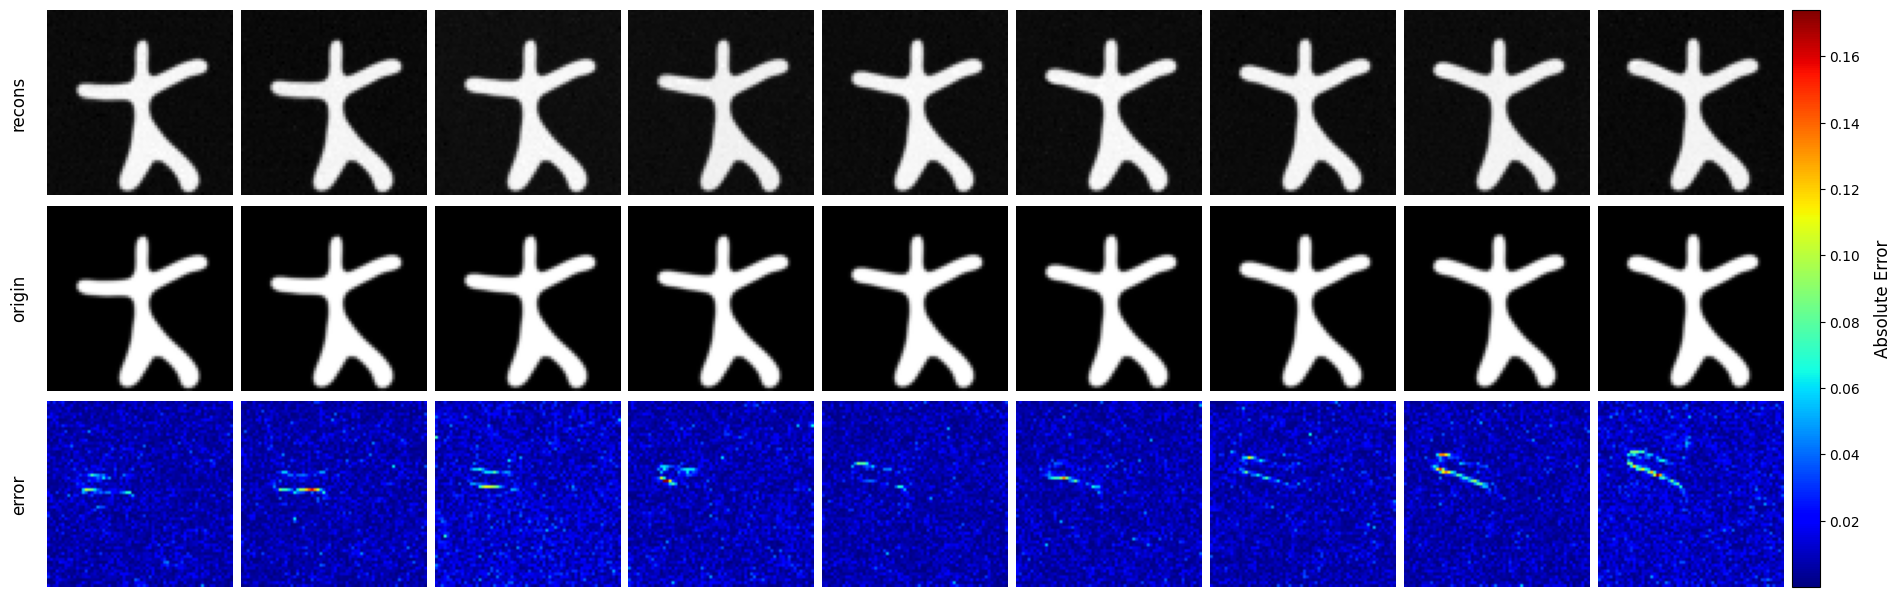

In [115]:
img_pred = img_lr_up + x_pred

fig = plot_comparison_starmen(
    imgs=[img_pred.squeeze(), img_hr.squeeze(), torch.abs(img_hr-img_pred).squeeze()],
    labels=["recons", "origin", "error"],
    is_errors=[False, False, True]
)

### Metrics

In [116]:

eval_dict = {
    "ids": [],
    "ages": [],
    "diff_ages": [],
    "ssim_metric": [],
    "mssim_metric": [],
    "psnr_metric": [],
    "l1err": [],
    "l2err": [],
    "lpips_metric": []
}

ssim_metric = self.ssim(img_pred, img_hr).mean().item()
mssim_metric = self.mssim(img_pred, img_hr).mean().item()
psnr_metric = self.psnr(img_pred, img_hr).mean().item()
l1err = torch.nn.functional.l1_loss(img_pred, img_hr, reduction="mean").item()
l2err = torch.nn.functional.mse_loss(img_pred, img_hr).item()
lpips_metric = self.lpips(img_pred, img_hr)

# write to eval dict
eval_dict["ids"].append(pidx)
eval_dict["ages"].append(ages.cpu().numpy())
eval_dict["diff_ages"].append(diff_ages.cpu().numpy())
eval_dict["ssim_metric"].append(ssim_metric)
eval_dict["mssim_metric"].append(mssim_metric)
eval_dict["psnr_metric"].append(psnr_metric)
eval_dict["lpips_metric"].append(lpips_metric)
eval_dict["l1err"].append(l1err)
eval_dict["l2err"].append(l2err)

eval_dict

{'ids': [33],
 'ages': [array([-2.3 , -1.39, -0.48,  0.44,  1.35,  2.27,  3.18,  4.09,  5.01],
        dtype=float32)],
 'diff_ages': [array([0.90999997, 0.90999997, 0.91999996, 0.91      , 0.91999996,
         0.9100001 , 0.9100001 , 0.9200001 , 0.90999985], dtype=float32)],
 'ssim_metric': [0.8030862212181091],
 'mssim_metric': [0.9929274320602417],
 'psnr_metric': [37.86589050292969],
 'l1err': [0.009508486837148666],
 'l2err': [0.00016863002383615822],
 'lpips_metric': [tensor(0.0216, grad_fn=<MeanBackward0>)]}

### function

In [346]:
@torch.no_grad()
def tadm_test_step_previous(self, batch, eval_dict, return_fig = False):
    """
    TADM test step using the previous scan as signal to predict the current scan
    """

    # subject metadata
    pidx = batch["id"].item()
    anomaly = batch["anomaly"].item()
    anomaly_type = batch["anomaly_type"][0]
    anomaly_gt_seg = batch["anomaly_gt_seg"]

    x0 = batch["x_origin"]
    img_lr = x0[:, :-1, ...]
    img_hr = x0[:, 1:, ...]
    img_hr = rearrange(img_hr, "b t ... -> (b t) ...")  # prior image
    img_lr = rearrange(img_lr, "b t ... -> (b t) ...")  # target image to predict
    img_lr_up = img_lr.clone()  # just to align with TADM source code. 

    # ages and diff ages
    ages = batch["age"][:, :-1, ...]
    diff_ages = torch.diff(batch["age"])
    diff_ages = rearrange(diff_ages, "b t ... -> (b t) ...")
    ages = rearrange(ages, "b t ... -> (b t) ...")

    # 1. Encoder image using RRDB network
    if self.args['use_rrdb']:
        self.encoder.eval()
        rrdb_out, cond = self.encoder(img_lr, True)
    else:
        rrdb_out = img_lr_up
        cond = img_lr

    # 2. Sampling x from trained TADMUnet
    x_pred = self.gaussian_diffusion.regular_tadm_sample(
        ddim_style="ddim10",
        encoder=self.encoder,
        unet=self.decoder,
        x_0=img_lr_up,
        x_T=torch.randn_like(img_lr_up),
        z=cond,
        diff_ages=diff_ages,
        ages=ages,
        disable_tqdm=False,
    )

    # 3. Reconstruc future image
    img_pred = img_lr_up + x_pred

    # Calculate eval metrics
    ssim_metric = self.ssim(img_pred, img_hr).mean().item()
    mssim_metric = self.mssim(img_pred, img_hr).mean().item()
    psnr_metric = self.psnr(img_pred, img_hr).mean().item()
    l1err = torch.nn.functional.l1_loss(img_pred, img_hr, reduction="mean").item()
    l2err = torch.nn.functional.mse_loss(img_pred, img_hr).item()
    lpips_metric = self.lpips(img_pred, img_hr).item()

    # write to eval dict
    eval_dict["ids"].append(pidx)
    eval_dict["ages"].append(ages.cpu().numpy())
    eval_dict["diff_ages"].append(diff_ages.cpu().numpy())
    eval_dict["ssim_metric"].append(ssim_metric)
    eval_dict["mssim_metric"].append(mssim_metric)
    eval_dict["psnr_metric"].append(psnr_metric)
    eval_dict["lpips_metric"].append(lpips_metric)
    eval_dict["l1err"].append(l1err)
    eval_dict["l2err"].append(l2err)

    # Plot comparison
    if return_fig: 
        fig = plot_comparison_starmen(
            imgs=[img_pred.squeeze(), img_hr.squeeze(), torch.abs(img_hr-img_pred).squeeze()],
            labels=["recons", "origin", "error"],
            is_errors=[False, False, True],
            opt={
                "title": "Predict current scan using previous scan (jump 1 timestep)"
            }
        )
        return eval_dict, fig
    else:
        return eval_dict
    

sampling loop time step: 100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


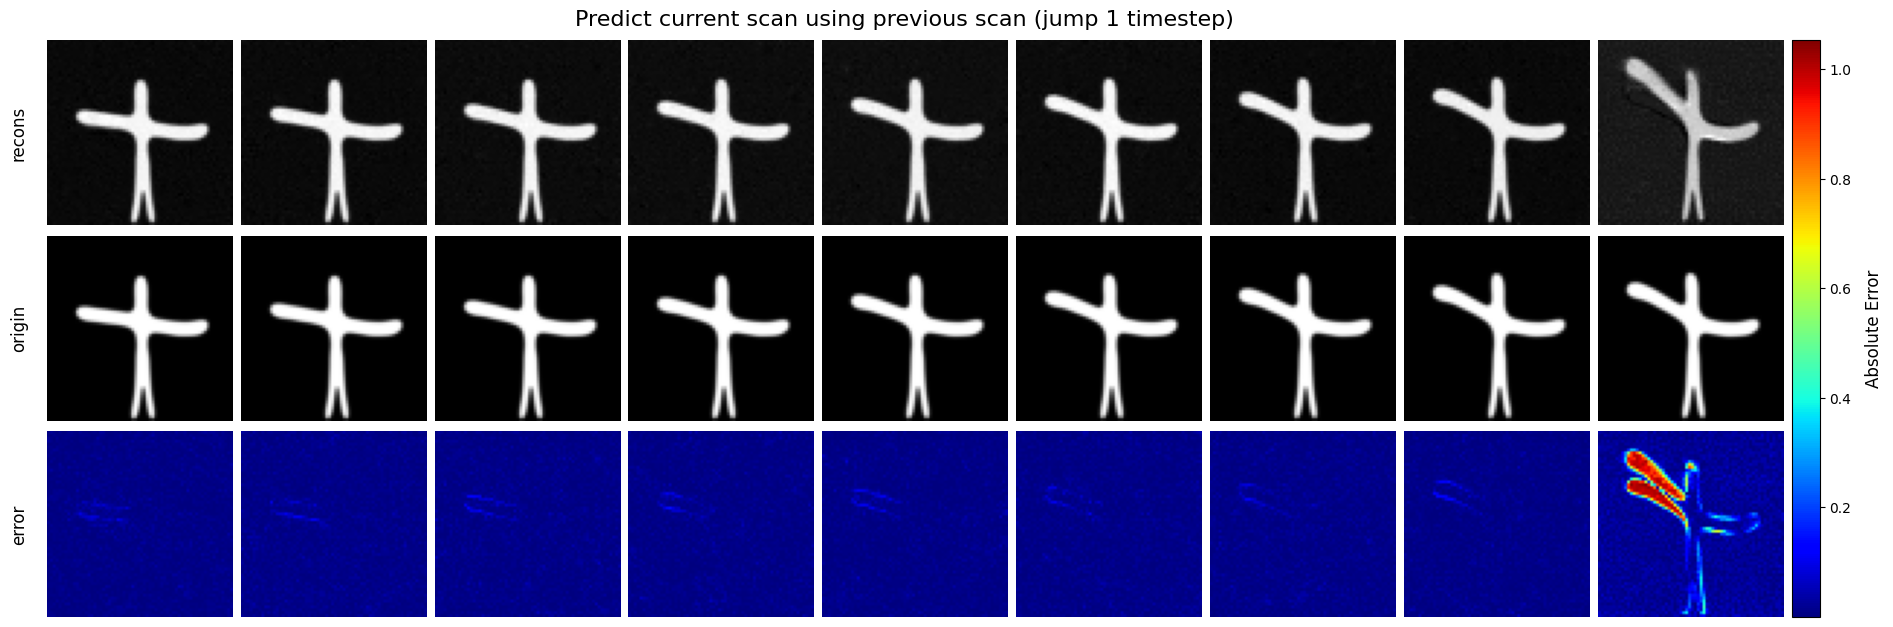

In [347]:
eval_dict_previous = {
    "ids": [],
    "ages": [],
    "diff_ages": [],
    "ssim_metric": [],
    "mssim_metric": [],
    "psnr_metric": [],
    "l1err": [],
    "l2err": [],
    "lpips_metric": []
}

eval_dict_previous, fig = tadm_test_step_previous(self, batch, eval_dict_previous, return_fig=True)

In [348]:
eval_dict_previous

{'ids': [184],
 'ages': [array([-2.1 , -1.18, -0.26,  0.66,  1.59,  2.51,  3.43,  4.35,  5.28],
        dtype=float32)],
 'diff_ages': [array([ 0.91999996,  0.91999996,  0.92      ,  0.93      ,  0.91999996,
          0.9200001 ,  0.91999984,  0.9300003 , 29.92      ], dtype=float32)],
 'ssim_metric': [0.675807535648346],
 'mssim_metric': [0.9681847095489502],
 'psnr_metric': [34.464332580566406],
 'l1err': [0.018344489857554436],
 'l2err': [0.005292369052767754],
 'lpips_metric': [0.0478692501783371]}

## Select random pair

In [89]:
batch = first(iter(growing_circle_loader))
x0 = batch["x_origin"]
x0.shape

all_ages = batch["age"]
all_ages.shape

# sample two distinct indices and sort them
b, t = all_ages.shape

nb_pair = 3
for i in range(nb_pair):
    idx = torch.stack([torch.randperm(t)[:2] for _ in range(b)])
    idx, _ = torch.sort(idx, dim=1)  # ensure a < b

    batch_idx = torch.arange(b)
    x = x0[batch_idx, idx[:,0]]  # (b, 1, 64, 64)
    x_target = x0[batch_idx, idx[:,1]]  # (b, 1, 64, 64)
    img_lr_up = img_lr.clone()

    age = all_ages[batch_idx, idx[:, 0]]
    age_target = all_ages[batch_idx, idx[:, 1]]
    diff_age = age_target - age

    if i == 0:
        img_lr = x
        img_hr = x_target
        ages = age
        diff_ages = diff_age
    else:
        img_lr = torch.cat((img_lr, x))
        img_hr = torch.cat((img_hr, x_target))
        ages = torch.cat((ages, age))
        diff_ages = torch.cat((diff_ages, diff_age))
        
img_lr_up = img_lr.clone()

print(all_ages)
print(idx)
print(diff_ages)
print(ages)

tensor([[-5.9800, -5.0800, -4.1800, -3.2800, -2.3800, -1.4800, -0.5800,  0.3100,
          1.2100,  2.1100]])
tensor([[6, 7]])
tensor([3.5900, 0.9000, 0.8900])
tensor([-2.3800, -2.3800, -0.5800])


In [90]:
with torch.no_grad():
    # 1. Encoder image using RRDB network
    if self.args['use_rrdb']:
        self.encoder.eval()
        rrdb_out, cond = self.encoder(img_lr, True)
    else:
        rrdb_out = img_lr_up
        cond = img_lr

    # 2. Sampling x from trained TADMUnet
    x_pred = self.gaussian_diffusion.regular_tadm_sample(
        ddim_style="ddim50",
        encoder=self.encoder,
        unet=self.decoder,
        x_0=img_lr_up,
        x_T=torch.randn_like(img_lr_up),
        z=cond,
        diff_ages=diff_ages,
        ages=ages,
        disable_tqdm=False,
    )

sampling loop time step: 100%|██████████| 50/50 [00:03<00:00, 15.92it/s]


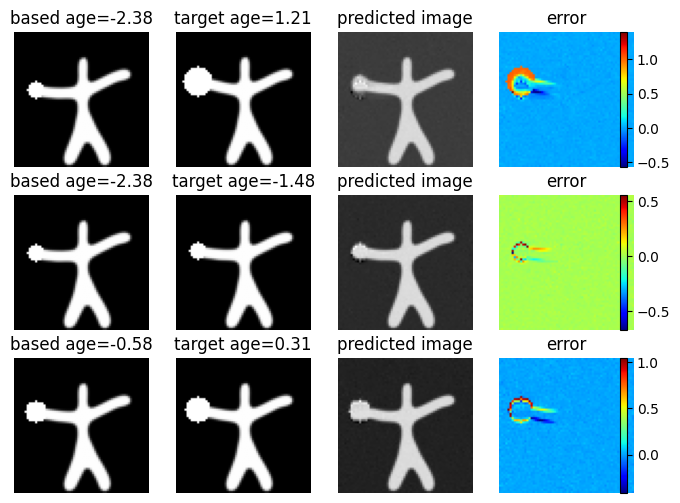

In [91]:
img_pred = img_lr_up + x_pred
img_pred.shape

l1err = torch.abs(img_hr - img_pred)

img_plots = torch.concat((img_hr[[0]].squeeze(), 
                          img_pred[[0]].squeeze(),
                          l1err[[0]].squeeze()), dim=1)
img_plots.shape

b = img_pred.shape[0]

fig, axes = plt.subplots(b, 4, figsize=(8, b*2))
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

for ax in axes.flatten():
    ax.axis("off")

for i in range(b):
    # based image
    ax = axes[i, 0]
    ax.imshow(img_lr_up[i].squeeze(), cmap="gray")
    ax.set_title(f"based age={ages[i]:.2f}")

    # taret image
    ax = axes[i, 1]
    ax.imshow(img_hr[i].squeeze(), cmap="gray")
    ax.set_title(f"target age={ages[i] + diff_ages[i]:.2f}")

    # recons image
    ax = axes[i, 2]
    ax.imshow(img_pred[i].squeeze(), cmap="gray")
    ax.set_title(f"predicted image")

    # diff
    ax = axes[i, 3]
    diff_img = img_hr[i] - img_pred[i]
    im = ax.imshow(diff_img.squeeze(), cmap="jet")
    ax.set_title("error")
    cax = inset_axes(ax,
                    width="5%",   # width relative to ax
                    height="100%",  # full height
                    loc='right',
                    )  
    fig.colorbar(im, cax=cax)
plt.subplots_adjust(hspace=0.2, wspace=0.2)

plt.savefig("notebooks/temp/tadm-randompair.svg")

### eval metrics

In [146]:
ssim_metric = self.ssim(img_pred, img_hr).cpu().numpy().squeeze()
mssim_metric = self.mssim(img_pred, img_hr).cpu().numpy().squeeze()
psnr_metric = self.psnr(img_pred, img_hr).cpu().numpy().squeeze()
l1err = torch.nn.functional.l1_loss(img_pred, img_hr, reduction="none").cpu().numpy()
l2err = torch.nn.functional.mse_loss(img_pred, img_hr, reduction="none").cpu().numpy()
l1err = np.mean(l1err, axis=(2, 3)).squeeze()
l2err = np.mean(l2err, axis=(2, 3)).squeeze()
lpips_metric = []
for i in range(img_pred.shape[0]):
    lpips_img = self.lpips(img_hr[[i]], img_pred[[i]])
    lpips_metric.append(lpips_img.item())

lpips_metric

[0.02949407324194908, 0.03481532633304596]

In [152]:
test = [pidx] * nb_pair
test

[184, 184]

### function


In [380]:
@torch.no_grad()
def tadm_test_step_random_pair(self, batch, eval_dict, return_fig = False, nb_pair=1):
    """
    TADM test step using a random pair from a batch
    """

    # subject metadata
    pidx = batch["id"].item()
    anomaly = batch["anomaly"].item()
    anomaly_type = batch["anomaly_type"][0]
    anomaly_gt_seg = batch["anomaly_gt_seg"]

    x0 = batch["x_origin"]
    img_lr = x0[:, :-1, ...]
    img_hr = x0[:, 1:, ...]
    img_hr = rearrange(img_hr, "b t ... -> (b t) ...")  # prior image
    img_lr = rearrange(img_lr, "b t ... -> (b t) ...")  # target image to predict
    img_lr_up = img_lr.clone()  # just to align with TADM source code. 

    # ages and diff ages
    all_ages = batch["age"]

    # select a random pair
    # sample two distinct indices and sort them
    b, t = all_ages.shape

    for i in range(nb_pair):
        idx = torch.stack([torch.randperm(t)[:2] for _ in range(b)])
        idx, _ = torch.sort(idx, dim=1)  # ensure a < b

        batch_idx = torch.arange(b)
        x = x0[batch_idx, idx[:,0]]  # (b, 1, 64, 64)
        x_target = x0[batch_idx, idx[:,1]]  # (b, 1, 64, 64)

        age = all_ages[batch_idx, idx[:, 0]]
        age_target = all_ages[batch_idx, idx[:, 1]]
        diff_age = age_target - age

        if i == 0:
            img_lr = x
            img_hr = x_target
            ages = age
            diff_ages = diff_age
        else:
            img_lr = torch.cat((img_lr, x))
            img_hr = torch.cat((img_hr, x_target))
            ages = torch.cat((ages, age))
            diff_ages = torch.cat((diff_ages, diff_age))
    
    img_lr_up = img_lr.clone()
    pidx = np.repeat(pidx, nb_pair)

    # 1. Encoder image using RRDB network
    if self.args['use_rrdb']:
        self.encoder.eval()
        rrdb_out, cond = self.encoder(img_lr, True)
    else:
        rrdb_out = img_lr_up
        cond = img_lr

    # 2. Sampling x from trained TADMUnet
    x_pred = self.gaussian_diffusion.regular_tadm_sample(
        ddim_style="ddim10",
        encoder=self.encoder,
        unet=self.decoder,
        x_0=img_lr_up,
        x_T=torch.randn_like(img_lr_up),
        z=cond,
        diff_ages=diff_ages,
        ages=ages,
        disable_tqdm=False,
    )

    # 3. Reconstruc future image
    img_pred = img_lr_up + x_pred

    # Calculate eval metrics
    ssim_metric = self.ssim(img_pred, img_hr).cpu().numpy().squeeze()
    mssim_metric = self.mssim(img_pred, img_hr).cpu().numpy().squeeze()
    psnr_metric = self.psnr(img_pred, img_hr).cpu().numpy().squeeze()
    l1err = torch.nn.functional.l1_loss(img_pred, img_hr, reduction="none").cpu().numpy()
    l2err = torch.nn.functional.mse_loss(img_pred, img_hr, reduction="none").cpu().numpy()
    l1err = np.mean(l1err, axis=(2, 3)).squeeze()
    l2err = np.mean(l2err, axis=(2, 3)).squeeze()
    lpips_metric = []
    for i in range(img_pred.shape[0]):
        lpips_img = self.lpips(img_hr[[i]], img_pred[[i]])
        lpips_metric.append(lpips_img.item())

    # write to eval dict
    eval_dict["ids"].append(pidx.tolist())
    eval_dict["ages"].append(ages.cpu().numpy().tolist())
    eval_dict["diff_ages"].append(diff_ages.cpu().numpy().tolist())
    eval_dict["ssim_metric"].append(ssim_metric.tolist())
    eval_dict["mssim_metric"].append(mssim_metric.tolist())
    eval_dict["psnr_metric"].append(psnr_metric.tolist())
    eval_dict["lpips_metric"].append(lpips_metric)
    eval_dict["l1err"].append(l1err.tolist())
    eval_dict["l2err"].append(l2err.tolist())

    # Plot comparison
    if return_fig: 
        title_fontsize = 10
        b = img_hr.shape[0]
        fig, axes = plt.subplots(b, 4, figsize=(8, b*2))
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes

        for ax in axes.flatten():
            ax.axis("off")

        for i in range(b):
            # based image
            ax = axes[i, 0]
            ax.imshow(img_lr_up[i].squeeze(), cmap="gray")
            ax.set_title(f"based age={ages[i]:.2f}", fontsize=title_fontsize)

            # taret image
            ax = axes[i, 1]
            ax.imshow(img_hr[i].squeeze(), cmap="gray")
            ax.set_title(f"target age={ages[i] + diff_ages[i]:.2f}", fontsize=title_fontsize)

            # recons image
            ax = axes[i, 2]
            ax.imshow(img_pred[i].squeeze(), cmap="gray")
            ax.set_title(f"predicted image", fontsize=title_fontsize)

            # diff
            ax = axes[i, 3]
            diff_img = img_hr[i] - img_pred[i]
            im = ax.imshow(diff_img.squeeze(), cmap="jet")
            ax.set_title("error", fontsize=title_fontsize)
            cax = inset_axes(ax,
                            width="5%",   # width relative to ax
                            height="100%",  # full height
                            loc='right',
                            )  
            fig.colorbar(im, cax=cax)
        plt.subplots_adjust(hspace=0.2, wspace=0.2)
        return eval_dict, fig
    else:
        return eval_dict

sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 15.03it/s]


{'ids': [[740, 740, 740]],
 'ages': [[-4.150000095367432, -0.25, -3.180000066757202]],
 'diff_ages': [[7.800000190734863, 2.9200000762939453, 5.850000381469727]],
 'ssim_metric': [[0.8582082390785217, 0.8421980142593384, 0.7294890880584717]],
 'mssim_metric': [[0.9866307377815247, 0.9928489923477173, 0.988210916519165]],
 'psnr_metric': [[30.401880264282227, 38.55343246459961, 33.448577880859375]],
 'l1err': [[0.012156065553426743, 0.008867103606462479, 0.01230626367032528]],
 'l2err': [[0.0009116161381825805,
   0.0001395266008330509,
   0.00045200384920462966]],
 'lpips_metric': [[0.031275320798158646,
   0.025564026087522507,
   0.0348120853304863]]}

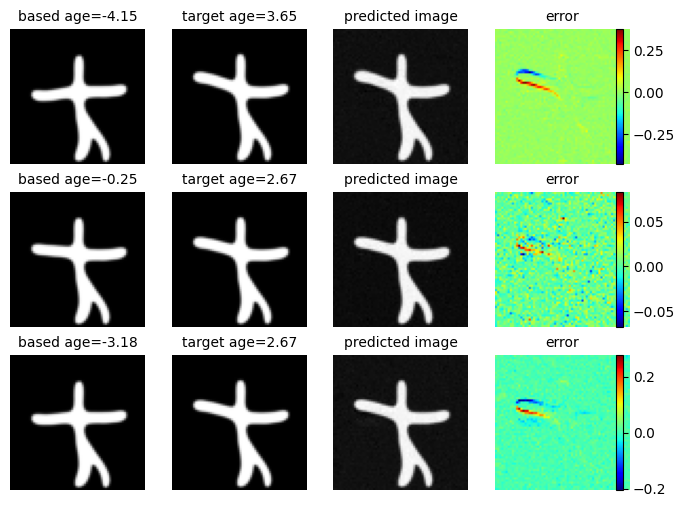

In [381]:
eval_dict_random_pair = {
    "ids": [],
    "ages": [],
    "diff_ages": [],
    "ssim_metric": [],
    "mssim_metric": [],
    "psnr_metric": [],
    "l1err": [],
    "l2err": [],
    "lpips_metric": []
}

batch = next(iter(test_loader))
eval_dict_random_pair, fig = tadm_test_step_random_pair(self, batch, eval_dict_random_pair, return_fig=True, nb_pair=3)

eval_dict_random_pair

## Test recon from the first image

tensor([-3.3200, -2.1100, -0.9000,  0.3200,  1.5300,  2.7400,  3.9600,  5.1700,
         6.3800,  7.6000])


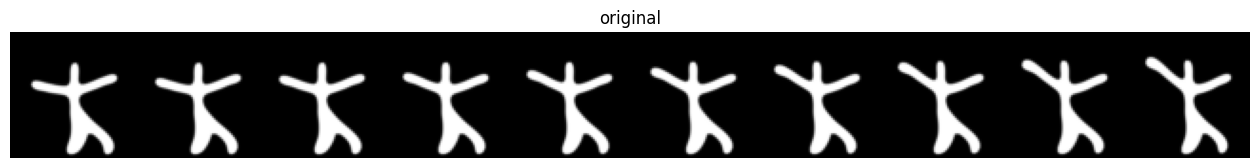

In [44]:
x0 = batch["x_origin"].squeeze(0)
quick_plot_tensor(x0, "original")

ages = batch["age"].squeeze()
print(ages)

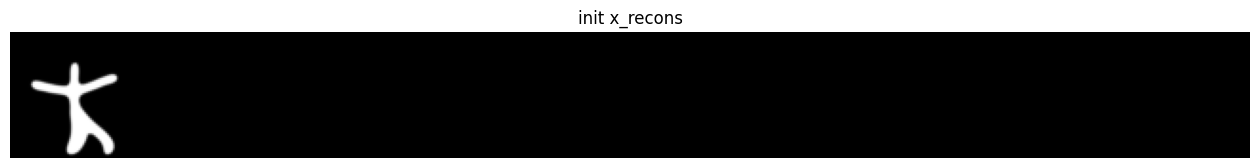

In [45]:
x_recons = torch.zeros_like(x0)
x_recons[0] = x0[0]
quick_plot_tensor(x_recons, "init x_recons")
prev_x = x_recons[0]
prev_age = ages[0]



In [46]:
# Reconstruct the whole sequence

for i, x in enumerate(x_recons):
    if i == 0:
        continue
    else:
        prev_x = x_recons[i-1]
        prev_age = ages[i-1]
        
        img_lr = prev_x.unsqueeze(0)
        diff_age = (ages[i] - prev_age).unsqueeze(0)

        # 1. encode image with RRDB
        rrdb_out, cond = self.encoder(img_lr, True)


        # 2. Sampling x from trained TADMUnet
        x_pred = self.gaussian_diffusion.regular_tadm_sample(
            ddim_style="ddim10",
            encoder=self.encoder,
            unet=self.decoder,
            x_0=img_lr,
            x_T=torch.randn_like(img_lr),
            z=cond,
            diff_ages=diff_age,
            ages=prev_age.unsqueeze(0),
            disable_tqdm=False,
        )

        x_recons[i] = (img_lr + x_pred).squeeze(0)


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 34.64it/s]


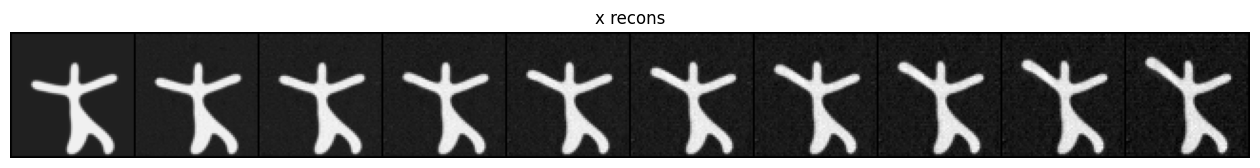

In [47]:
quick_plot_tensor(x_recons, "x recons")

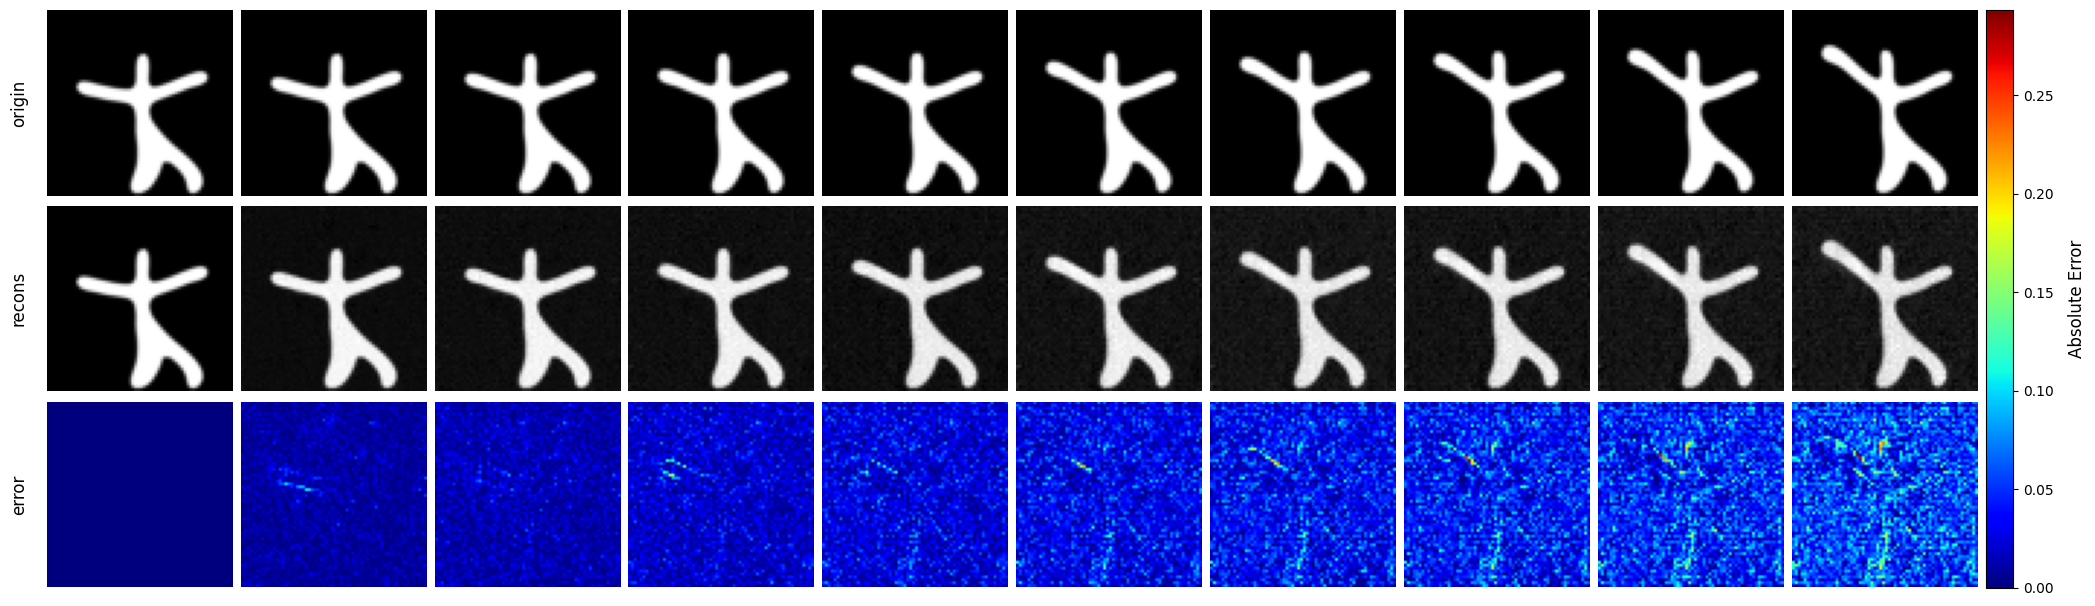

In [48]:
fig = plot_comparison_starmen(
    imgs=[x0.squeeze(), 
          x_recons.squeeze(),
          torch.abs(x0-x_recons).squeeze()],
    labels=["origin", "recons", "error"],
    is_errors=[False, False, True]
)

## Test with masked input

tensor([-5.9800, -5.0800, -4.1800, -3.2800, -2.3800, -1.4800, -0.5800,  0.3100,
         1.2100,  2.1100])


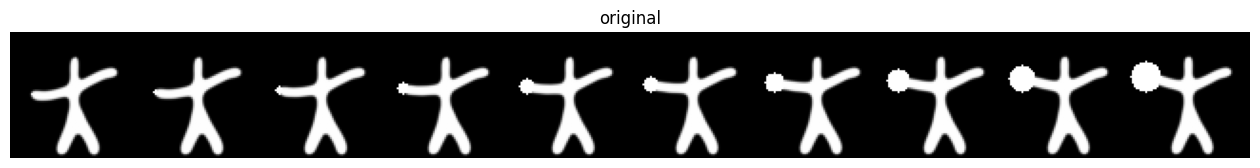

In [69]:
import random

batch = first(iter(growing_circle_loader))

self = tadm_litmodel

x0 = batch["x_origin"].squeeze(0)
quick_plot_tensor(x0, "original")

ages = batch["age"].squeeze()
print(ages)

tensor([1., 0., 0., 0., 0., 0., 0., 0., 1., 0.])


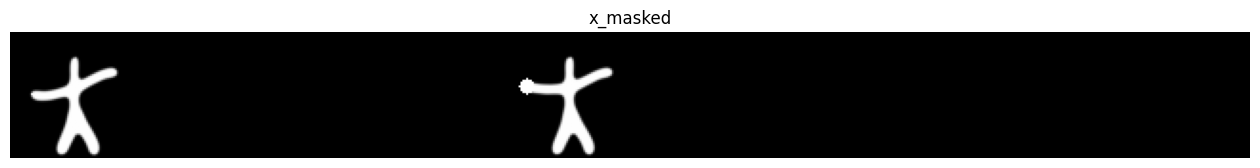

In [70]:
t, c, h, w = x0.shape

seen_mask = torch.full((t,), 0.)
perc_seen = 0.2
nb_seen = int(perc_seen * t)

seen_idxs = torch.randperm(t - 1)[:nb_seen-1] + 1
seen_mask[seen_idxs] = 1.
seen_mask[0] = 1.

# # only recons from the 1st image
# seen_mask[1:] = 0.

print(seen_mask)

# Fix seen_mask
seen_mask = torch.full((t,), 0.)
seen_mask[[0, 4]] = 1.
x_masked = x0 * rearrange(seen_mask, "t -> t 1 1 1")
ages_masked = ages * seen_mask

quick_plot_tensor(x_masked, "x_masked")

In [71]:
x_recons = x_masked.clone()

prev_x = x_recons[0]
prev_age = ages[0]

with torch.no_grad():
    for i, x in enumerate(x_recons):
        if seen_mask[i] == 1.:
            prev_x = x
            prev_age = ages[i]
        else:
            img_lr = prev_x.unsqueeze(0)

            diff_age = (ages[i] - prev_age).unsqueeze(0)
            print(diff_age)
            
            # 1. encode image with RRDB
            self.encoder.eval()
            rrdb_out, cond = self.encoder(img_lr, True)

            # 2. Sampling x from trained TADMUnet
            x_pred = self.gaussian_diffusion.regular_tadm_sample(
                ddim_style="ddim50",
                encoder=self.encoder,
                unet=self.decoder,
                x_0=img_lr,
                x_T=torch.randn_like(img_lr),
                z=cond,
                diff_ages=diff_age,
                ages=prev_age.unsqueeze(0),
                disable_tqdm=False,
            )

            # 3. Predict future image
            img_pred = (img_lr + x_pred).squeeze(0)
            x_recons[i] = img_pred
            prev_x = img_pred
            prev_age = ages[i]


tensor([0.9000])


sampling loop time step: 100%|██████████| 50/50 [00:01<00:00, 36.02it/s]


tensor([0.9000])


sampling loop time step: 100%|██████████| 50/50 [00:01<00:00, 34.10it/s]


tensor([0.9000])


sampling loop time step: 100%|██████████| 50/50 [00:01<00:00, 31.94it/s]


tensor([0.9000])


sampling loop time step: 100%|██████████| 50/50 [00:01<00:00, 34.51it/s]


tensor([0.9000])


sampling loop time step: 100%|██████████| 50/50 [00:01<00:00, 33.50it/s]


tensor([0.8900])


sampling loop time step: 100%|██████████| 50/50 [00:01<00:00, 34.55it/s]


tensor([0.9000])


sampling loop time step: 100%|██████████| 50/50 [00:01<00:00, 35.20it/s]


tensor([0.9000])


sampling loop time step: 100%|██████████| 50/50 [00:01<00:00, 33.09it/s]


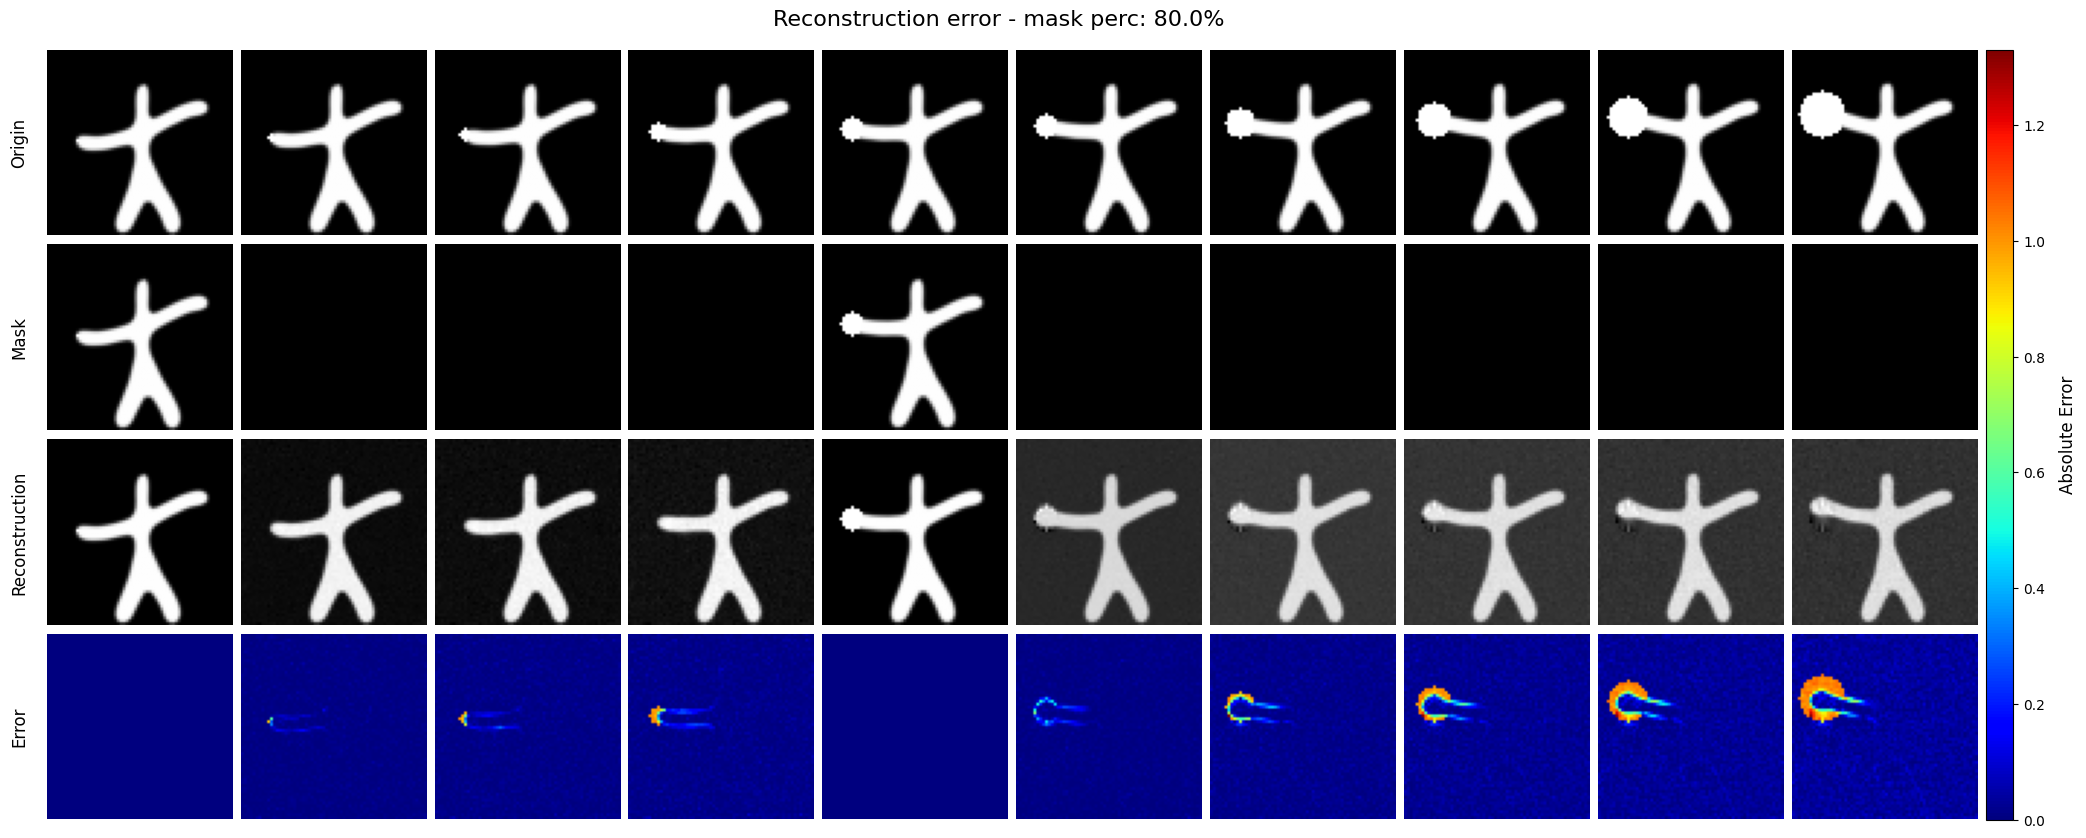

In [73]:
# Plot comparison
imgs = [
    x0.detach().cpu().squeeze(), 
    x_masked.detach().cpu().squeeze(),
    x_recons.detach().cpu().squeeze(),
    torch.abs(x0 - x_recons).detach().cpu().squeeze(),
]

labels = [
    "Origin",
    "Mask",
    "Reconstruction",
    "Error"
]

opt = {
    "title": f"Reconstruction error - mask perc: {1 - perc_seen:.1%}"
}

fig = plot_comparison_starmen(imgs, labels, is_errors=[False, False, False, True], opt=opt)
fig.savefig("notebooks/temp/tadm-impute-gcircle.svg")

### function

In [368]:
@torch.no_grad()
def tadm_test_step_masked_input(self, batch, eval_dict, return_fig = False, perc_seen=0.2):
    """
    TADM test step using the previous scan as signal to predict the current scan
    """

    # subject metadata
    pidx = batch["id"].item()
    anomaly = batch["anomaly"].item()
    anomaly_type = batch["anomaly_type"][0]
    anomaly_gt_seg = batch["anomaly_gt_seg"]

    x0 = batch["x_origin"].squeeze(0)
    ages = batch["age"].squeeze()

    # generate mask
    t, c, h, w = x0.shape

    seen_mask = torch.full((t,), 0.)
    nb_seen = int(perc_seen * t)

    seen_idxs = torch.randperm(t - 1)[:nb_seen-1] + 1
    seen_mask[seen_idxs] = 1.
    seen_mask[0] = 1.

    x_masked = x0 * rearrange(seen_mask, "t -> t 1 1 1")
    ages_masked = ages * seen_mask

    # Generate the whole sequence from masked input
    x_recons = x_masked.clone()
    prev_x = x_recons[0]

    for i, x in enumerate(x_recons):
        if seen_mask[i] == 1.:
            prev_x = x
            prev_age = ages[i]
        else:
            img_lr = prev_x.unsqueeze(0)

            diff_age = (ages[i] - prev_age).unsqueeze(0)
            print(diff_age)
            
            # 1. encode image with RRDB
            self.encoder.eval()
            rrdb_out, cond = self.encoder(img_lr, True)


            # 2. Sampling x from trained TADMUnet
            x_pred = self.gaussian_diffusion.regular_tadm_sample(
                ddim_style="ddim10",
                encoder=self.encoder,
                unet=self.decoder,
                x_0=img_lr,
                x_T=torch.randn_like(img_lr),
                z=cond,
                diff_ages=diff_age,
                ages=prev_age.unsqueeze(0),
                disable_tqdm=False,
            )

            # 3. Predict future image
            img_pred = (img_lr + x_pred).squeeze(0)
            x_recons[i] = img_pred
            prev_x = img_pred
            prev_age = ages[i]

    # Calculate eval metrics
    img_pred = x_recons[seen_mask == 0.]
    img_hr = x0[seen_mask == 0.]

    ssim_metric = self.ssim(img_pred, img_hr).mean().item()
    mssim_metric = self.mssim(img_pred, img_hr).mean().item()
    psnr_metric = self.psnr(img_pred, img_hr).mean().item()
    l1err = torch.nn.functional.l1_loss(img_pred, img_hr, reduction="mean").item()
    l2err = torch.nn.functional.mse_loss(img_pred, img_hr).item()
    lpips_metric = self.lpips(img_pred, img_hr).item()

    # write to eval dict
    eval_dict["ids"].append(pidx)
    # eval_dict["ages"].append(ages.cpu().numpy())
    # eval_dict["diff_ages"].append(diff_ages.cpu().numpy())
    eval_dict["perc_seen"].append(perc_seen)
    eval_dict["mask"].append(seen_mask.numpy().tolist())
    eval_dict["ssim_metric"].append(ssim_metric)
    eval_dict["mssim_metric"].append(mssim_metric)
    eval_dict["psnr_metric"].append(psnr_metric)
    eval_dict["lpips_metric"].append(lpips_metric)
    eval_dict["l1err"].append(l1err)
    eval_dict["l2err"].append(l2err)

    # Plot comparison
    if return_fig: 
        # Plot comparison
        imgs = [
            x0.detach().cpu().squeeze(), 
            x_masked.detach().cpu().squeeze(),
            x_recons.detach().cpu().squeeze(),
            torch.abs(x0 - x_recons).detach().cpu().squeeze(),
        ]

        labels = [
            "Origin",
            "Mask",
            "Reconstruction",
            "Error"
        ]
        opt = {
            "title": f"Reconstruction error - mask %: {perc_seen}"
        }

        fig = plot_comparison_starmen(imgs, labels, is_errors=[False, False, False, True], opt=opt)
        return eval_dict, fig
    else:
        return eval_dict

In [352]:
perc_seen_list = np.arange(0.1, 0.6, 0.1)
perc_seen_list
for p in perc_seen_list:
    print(p)

0.1
0.2
0.30000000000000004
0.4
0.5


In [370]:
batch = next(iter(test_loader))

tensor([1.0800])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 29.46it/s]


tensor([1.0900])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 29.43it/s]


tensor([1.0800])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 30.18it/s]


tensor([1.0800])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 30.87it/s]


tensor([1.0800])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 20.99it/s]


tensor([1.0800])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 31.02it/s]


tensor([1.0900])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 30.78it/s]


tensor([1.0800])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 28.87it/s]


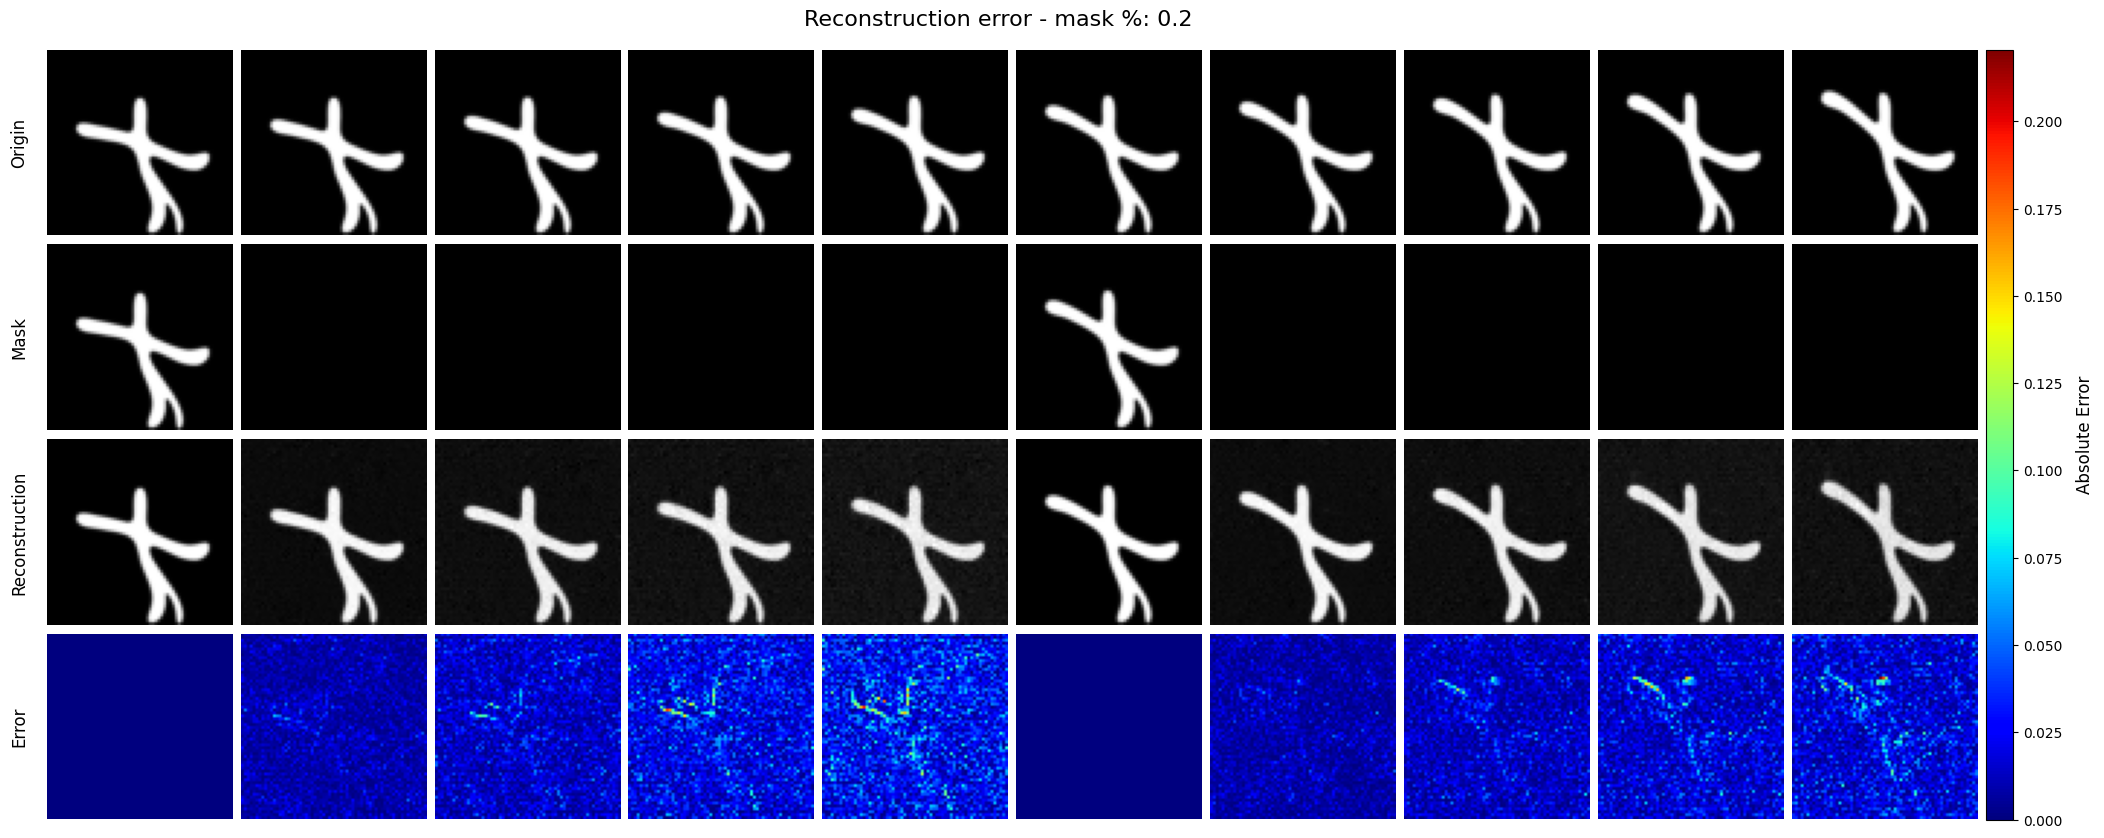

In [371]:
eval_dict_masked_input = {
    "ids": [],
    "mask": [],
    "perc_seen": [],
    "ages": [],
    "diff_ages": [],
    "ssim_metric": [],
    "mssim_metric": [],
    "psnr_metric": [],
    "l1err": [],
    "l2err": [],
    "lpips_metric": []
}

eval_dict, *out = tadm_test_step_masked_input(self, batch, eval_dict=eval_dict_masked_input, perc_seen=0.2, return_fig=True)

In [354]:
eval_dict_masked_input

{'ids': [184],
 'mask': [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]],
 'perc_seen': [0.1],
 'ages': [],
 'diff_ages': [],
 'ssim_metric': [0.3112286329269409],
 'mssim_metric': [0.9339326024055481],
 'psnr_metric': [26.752635955810547],
 'l1err': [0.0411844365298748],
 'l2err': [0.007350092753767967],
 'lpips_metric': [0.13009655475616455]}

## Oversample

In [79]:
batch = first(iter(test_loader))

x0 = batch["x_origin"].squeeze(0)
ages = batch["age"].squeeze()

ages.shape

torch.Size([10])

In [80]:
img_lr = x0[9].unsqueeze(0)
img_lr.shape
prev_age = ages[9].unsqueeze(0)
prev_age

oversample_step = 7
x_oversample = torch.zeros((oversample_step, 1, 64, 64))

with torch.no_grad():
    for i in range(oversample_step):
        diff_age = torch.tensor([1.])
        print(diff_age)
        
        # 1. encode image with RRDB
        self.encoder.eval()
        rrdb_out, cond = self.encoder(img_lr, True)


        # 2. Sampling x from trained TADMUnet
        x_pred = self.gaussian_diffusion.regular_tadm_sample(
            ddim_style="ddim50",
            encoder=self.encoder,
            unet=self.decoder,
            x_0=img_lr,
            x_T=torch.randn_like(img_lr),
            z=cond,
            diff_ages=diff_age,
            ages=prev_age,
            disable_tqdm=False,
        )

        # 3. Predict future image
        img_pred = (img_lr + x_pred)
        x_oversample[i] = img_pred.squeeze(0)
        img_lr = img_pred
        prev_age += diff_age



tensor([1.])


sampling loop time step: 100%|██████████| 50/50 [00:01<00:00, 33.64it/s]


tensor([1.])


sampling loop time step: 100%|██████████| 50/50 [00:01<00:00, 33.62it/s]


tensor([1.])


sampling loop time step: 100%|██████████| 50/50 [00:01<00:00, 31.32it/s]


tensor([1.])


sampling loop time step: 100%|██████████| 50/50 [00:01<00:00, 33.74it/s]


tensor([1.])


sampling loop time step: 100%|██████████| 50/50 [00:01<00:00, 33.73it/s]


tensor([1.])


sampling loop time step: 100%|██████████| 50/50 [00:01<00:00, 34.80it/s]


tensor([1.])


sampling loop time step: 100%|██████████| 50/50 [00:01<00:00, 36.05it/s]


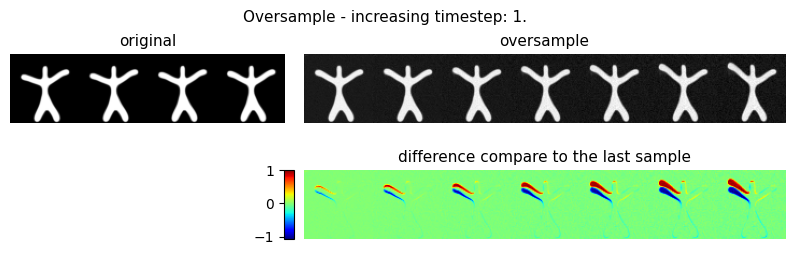

In [81]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 3))
gs = gridspec.GridSpec(2, 2, 
                       figure=fig,
                       width_ratios=[4, 7], 
                       height_ratios=[1, 1] )

fig.subplots_adjust(
    # left=0.05, right=0.95,  # shrink/grow figure margins
    # bottom=0.1, top=1.0,
    wspace=0.05, hspace=0.0  # spacing between subplots
)

ax1 = fig.add_subplot(gs[0, 0])    
ax2 = fig.add_subplot(gs[0, 1])     
ax3 = fig.add_subplot(gs[1, 1])     
# ax_cb = fig.add_subplot(gs[1, 0]) 

# original sequence
img = x0[6:]
img = rearrange(img, "b c h w -> h (b c w)")
ax1.imshow(img, cmap="gray") 
ax1.axis("off")
ax1.set_title("original")

# oversample sequence
img = rearrange(x_oversample, "b c h w -> h (b c w)")
ax2.imshow(img, cmap="gray") 
ax2.axis("off")
ax2.set_title("oversample")

# difference
img = x_oversample - x0[-1]
img = rearrange(img, "b c h w -> h (b c w)")
im = ax3.imshow(img, cmap="jet") 
ax3.axis("off")
ax3.set_title("difference compare to the last sample")


bbox = ax3.get_position()  # [x0, y0, width, height] in figure coords
cax = fig.add_axes([bbox.x0 - 0.02, bbox.y0, 0.01, bbox.height])  
# [left, bottom, width, height] in figure coordinates

cbar = fig.colorbar(im, cax=cax)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('left')

for ax in fig.get_axes():  # get all axes in the figure
    ax.title.set_fontsize(11)
fig.suptitle(f"Oversample - increasing timestep: 1.", fontsize=11, y=0.95)

# plt.tight_layout()
fig.savefig("notebooks/temp/tadm-oversample.svg")

### function

In [341]:
@torch.no_grad()
def tadm_test_step_oversample(self, batch, oversample_step=7):
    """
    TADM test step with oversample from the last sample
    """

    # subject metadata
    pidx = batch["id"].item()

    x0 = batch["x_origin"].squeeze(0)
    ages = batch["age"].squeeze()

    # Start from the last 
    img_lr = x0[9].unsqueeze(0)
    img_lr.shape
    prev_age = ages[9].unsqueeze(0)
    prev_age

    x_oversample = torch.zeros((oversample_step, 1, 64, 64))

    for i in range(oversample_step):
        diff_age = torch.tensor([1.])
        print(diff_age)
        
        # 1. encode image with RRDB
        self.encoder.eval()
        rrdb_out, cond = self.encoder(img_lr, True)


        # 2. Sampling x from trained TADMUnet
        x_pred = self.gaussian_diffusion.regular_tadm_sample(
            ddim_style="ddim10",
            encoder=self.encoder,
            unet=self.decoder,
            x_0=img_lr,
            x_T=torch.randn_like(img_lr),
            z=cond,
            diff_ages=diff_age,
            ages=prev_age,
            disable_tqdm=False,
        )

        # 3. Predict future image
        img_pred = (img_lr + x_pred)
        x_oversample[i] = img_pred.squeeze(0)
        img_lr = img_pred
        prev_age += diff_age
    
    # Plot
    import matplotlib.gridspec as gridspec

    fig = plt.figure(figsize=(10, 3))
    gs = gridspec.GridSpec(2, 2, 
                        figure=fig,
                        width_ratios=[4, 7], 
                        height_ratios=[1, 1] )

    fig.subplots_adjust(
        # left=0.05, right=0.95,  # shrink/grow figure margins
        # bottom=0.1, top=1.0,
        wspace=0.05, hspace=0.0  # spacing between subplots
    )

    ax1 = fig.add_subplot(gs[0, 0])    
    ax2 = fig.add_subplot(gs[0, 1])     
    ax3 = fig.add_subplot(gs[1, 1])     
    # ax_cb = fig.add_subplot(gs[1, 0]) 

    # original sequence
    img = x0[6:]
    img = rearrange(img, "b c h w -> h (b c w)")
    ax1.imshow(img, cmap="gray") 
    ax1.axis("off")
    ax1.set_title("original")

    # oversample sequence
    img = rearrange(x_oversample, "b c h w -> h (b c w)")
    ax2.imshow(img, cmap="gray") 
    ax2.axis("off")
    ax2.set_title("oversample")

    # difference
    img = x_oversample - x0[-1]
    img = rearrange(img, "b c h w -> h (b c w)")
    im = ax3.imshow(img, cmap="jet") 
    ax3.axis("off")
    ax3.set_title("difference compare to the last sample")


    bbox = ax3.get_position()  # [x0, y0, width, height] in figure coords
    cax = fig.add_axes([bbox.x0 - 0.02, bbox.y0, 0.01, bbox.height])  
    # [left, bottom, width, height] in figure coordinates

    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.yaxis.set_ticks_position('left')
    cbar.ax.yaxis.set_label_position('left')

    for ax in fig.get_axes():  # get all axes in the figure
        ax.title.set_fontsize(11)
    fig.suptitle(f"Oversample - idx: {pidx} - increasing timestep: 1.", fontsize=11, y=0.95)
    return fig


tensor([1.])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 31.71it/s]


tensor([1.])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 23.38it/s]


tensor([1.])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 32.41it/s]


tensor([1.])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 31.48it/s]


tensor([1.])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 33.56it/s]


tensor([1.])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 30.14it/s]


tensor([1.])


sampling loop time step: 100%|██████████| 10/10 [00:00<00:00, 31.49it/s]


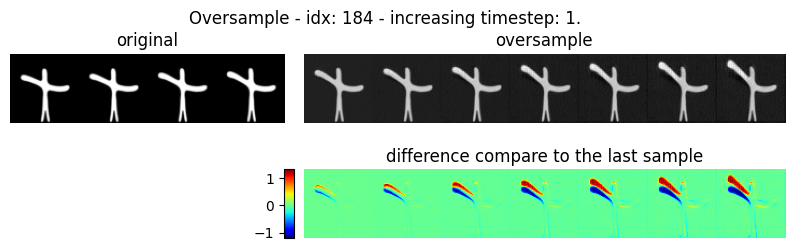

In [340]:
fig = tadm_test_step_oversample(self, batch, oversample_step=5)

# Concat results

In [9]:
import json
import pandas as pd

In [46]:
def format_extremes(x, col_name, df):
    """x is a scalar; col_name is a tuple for MultiIndex"""
    rule = highlight_rule[col_name]
    if rule == "max":
        return f"\\textbf{{{x:.3f}}}" if x == df[col_name].max() else f"{x:.3f}"
    else:
        return f"\\textbf{{{x:.3f}}}" if x == df[col_name].min() else f"{x:.3f}"

## Previous images

In [29]:
# Read eval dict file

ano_types = ["test", "growing_circle20", "darker_circle20", "darker_line20"]
ano_text = ["healthy", "growing_circle", "darker_circle", "darker_line"]
df_ls = []

for i, ano in enumerate(ano_types): 

    eval_dict_path = f"workdir/diffae_starmen/infer/tadm/{ano}_ddim100_noise250/results/eval_dict_previous.json"
    with open(eval_dict_path, "r") as f:
        eval_dict_previous = json.load(f)

    eval_dict_previous.keys()
    select_keys = list(eval_dict_previous.keys())
    select_keys.remove("diff_ages")
    select_keys
    metric_keys = ["ssim_metric", "mssim_metric", "psnr_metric", "lpips_metric", "l1err", "l2err"]

    metric_texts = [
        r'SSIM $\uparrow$',
        r'MSSIM $\uparrow$',
        r'PSNR $\uparrow$',
        r"LPIPS $\downarrow$",
        r'$l1 \mathrm{-error}$ (e-3) $\downarrow$',
        r'$l2 \mathrm{-error}$ (e-3) $\downarrow$'
    ]

    # Create pandas table
    df = pd.DataFrame(eval_dict_previous)
    df = df[select_keys]
    df

    df_mean = df[metric_keys].mean().to_frame().T
    df_mean.index = [ano]
    df_mean

    df_ls.append(df_mean)


In [34]:
# Concat results
df = pd.concat(df_ls)
df
df["ssim"] = df["ssim_metric"] * 100
df["mssim"] = df["mssim_metric"] * 100
df["psnr"] = df["psnr_metric"]
df["lpips"] = df["lpips_metric"] * 1e3
df["l1"] = df["l1err"] * 1e3
df["l2"] = df["l2err"] * 1e3


# Format table
metric_keys = ["ssim", "mssim", "psnr", "lpips", "l1", "l2"]

metric_texts = [
    r'SSIM \textupparrow',
    r'MSSIM \textuparrow',
    r'PSNR \textuparrow',
    r"LPIPS (e-3) \textdownarrow",
    r'$l1 \mathrm{-error}$ (e-3) \textdownarrow',
    r'$l2 \mathrm{-error}$ (e-3) \textdownarrow'
]

df = df[metric_keys]
df.columns = metric_texts
df

SSIM \textupparrow  MSSIM \textuparrow  PSNR \textuparrow  \
test                       77.262912           99.172524          37.400088   
growing_circle20           75.022063           97.716430          23.967974   
darker_circle20            76.683148           99.071361          33.050242   
darker_line20              75.824310           98.903768          31.729325   

                  LPIPS (e-3) \textdownarrow  \
test                               26.614482   
growing_circle20                   33.702087   
darker_circle20                    29.191589   
darker_line20                      29.309845   

                  $l1 \mathrm{-error}$ (e-3) \textdownarrow  \
test                                               9.901295   
growing_circle20                                  17.768596   
darker_circle20                                   10.994352   
darker_line20                                     11.604782   

                  $l2 \mathrm{-error}$ (e-3) \textdownarrow  
test                                               0.186388  
growing_circle20                                   6.306070  
darker_circle20                                    0.515649  
darker_line20                                      0.705167

In [36]:

latex_table = df.to_latex(
    index=True,
    float_format="%.2f",
    caption="TADM with previous images",
    label="tab:tadm-previous"
)

print(latex_table)

\begin{table}
\caption{TADM with previous images}
\label{tab:tadm-previous}
\begin{tabular}{lrrrrrr}
\toprule
 & SSIM \textupparrow & MSSIM \textuparrow & PSNR \textuparrow & LPIPS (e-3) \textdownarrow & $l1 \mathrm{-error}$ (e-3) \textdownarrow & $l2 \mathrm{-error}$ (e-3) \textdownarrow \\
\midrule
test & 77.26 & 99.17 & 37.40 & 26.61 & 9.90 & 0.19 \\
growing_circle20 & 75.02 & 97.72 & 23.97 & 33.70 & 17.77 & 6.31 \\
darker_circle20 & 76.68 & 99.07 & 33.05 & 29.19 & 10.99 & 0.52 \\
darker_line20 & 75.82 & 98.90 & 31.73 & 29.31 & 11.60 & 0.71 \\
\bottomrule
\end{tabular}
\end{table}



## Random pair

In [52]:
# Read eval dict file
eval_dict_path = "workdir/diffae_starmen/infer/tadm/test_ddim100_noise250/results/eval_dict_random_pair.json"
with open(eval_dict_path, "r") as f:
    eval_dict_random_pair = json.load(f)

eval_dict_random_pair.keys()
eval_dict_random_pair_flat = {k: np.array(v).flatten().tolist() for k, v in eval_dict_random_pair.items()}

metric_keys = ["ssim_metric", "mssim_metric", "psnr_metric", "l1err", "l2err", "lpips_metric"]

# Create pandas table
df = pd.DataFrame(eval_dict_random_pair_flat)
df["diff_ages"].max()

# Creat diff_age bin
bins = range(0, 13)  
diff_age_bins = [f"{i}-{i+1}" for i in range(len(bins)-1)]
diff_age_bins
df["diff_age_group"] = pd.cut(df["diff_ages"], bins=bins, labels=diff_age_bins, right=False)
df

ids  ages  diff_ages  ssim_metric  mssim_metric  psnr_metric     l1err  \
0      2 -3.08       7.27     0.853449      0.989148    33.758602  0.011390   
1      2  3.28       0.91     0.854138      0.991977    38.409790  0.008724   
2      2  0.55       1.82     0.807461      0.991394    37.567684  0.009801   
3      2  0.55       3.64     0.843090      0.989147    31.879745  0.011465   
4      2 -3.99       4.54     0.859508      0.989978    35.383114  0.010009   
..   ...   ...        ...          ...           ...          ...       ...   
745  998  5.48       1.15     0.774482      0.991188    37.487049  0.009790   
746  998 -1.37      10.28     0.814023      0.982710    28.136414  0.016098   
747  998 -1.37       4.57     0.744044      0.990043    35.528831  0.011647   
748  998  2.06       5.71     0.720884      0.986772    29.858675  0.014634   
749  998  4.34       1.14     0.868905      0.991679    36.595863  0.009145   

        l2err  lpips_metric diff_age_group  
0    0.000421      0.029221            7-8  
1    0.000144      0.027832            0-1  
2    0.000175      0.025253            1-2  
3    0.000649      0.029358            3-4  
4    0.000290      0.030029            4-5  
..        ...           ...            ...  
745  0.000178      0.031143            1-2  
746  0.001536      0.027222          10-11  
747  0.000280      0.034454            4-5  
748  0.001033      0.036285            5-6  
749  0.000219      0.023956            1-2  

[750 rows x 10 columns]

In [53]:
# Calculate mean 

df_mean = df.groupby("diff_age_group")[metric_keys].mean()
df_mean

# Change unit and format table
df_mean["ssim"] = df_mean["ssim_metric"] * 100
df_mean["mssim"] = df_mean["mssim_metric"] * 100
df_mean["psnr"] = df_mean["psnr_metric"]
df_mean["lpips"] = df_mean["lpips_metric"] * 1e3
df_mean["l1"] = df_mean["l1err"] * 1e3
df_mean["l2"] = df_mean["l2err"] * 1e3


# Format table
metric_keys = ["ssim", "mssim", "psnr", "lpips", "l1", "l2"]

metric_texts = [
    r'SSIM \textuparrow',
    r'MSSIM \textuparrow',
    r'PSNR \textuparrow',
    r"LPIPS (e-3) \textdownarrow",
    r'$l1$-error (e-3) \textdownarrow',
    r'$l2$-error (e-3) \textdownarrow'
]

df_mean = df_mean[metric_keys]
df_mean

/tmp/ipykernel_8056/976806734.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_mean = df.groupby("diff_age_group")[metric_keys].mean()


ssim      mssim       psnr      lpips         l1  \
diff_age_group                                                          
0-1             84.882274  99.157897  38.265735  25.867462   9.001172   
1-2             83.955480  99.117601  36.777955  26.512786   9.768540   
2-3             83.422003  99.037046  34.670360  28.398048  10.834927   
3-4             84.150253  98.921304  32.523547  28.876834  11.828012   
4-5             83.235045  98.826219  31.842972  29.617920  12.453490   
5-6             82.771966  98.744391  30.905793  31.476237  13.255045   
6-7             83.273268  98.634574  30.372104  31.265846  14.002390   
7-8             82.625494  98.532130  29.579907  32.333019  14.432320   
8-9             83.879739  98.563663  29.427332  29.820760  14.433028   
9-10            83.127331  98.507085  29.098582  27.434405  15.177560   
10-11           83.329098  98.473306  28.869687  25.325428  15.435952   
11-12           76.029086  98.372927  26.883677  29.327393  17.134034   

                      l2  
diff_age_group            
0-1             0.150686  
1-2             0.225626  
2-3             0.362201  
3-4             0.630021  
4-5             0.773707  
5-6             0.897927  
6-7             1.040200  
7-8             1.215347  
8-9             1.288796  
9-10            1.440172  
10-11           1.371761  
11-12           2.077817

In [55]:
# Export to Latex table
highlight_rule = {
    "ssim": "min",
    "mssim": "max",
    "psnr": "max",
    "lpips": "min",
    "l1": "min",
    "l2": "min"
}

# Apply formatting per column
fmt_dict = {col: (lambda x, col_name=col: format_extremes(x, col_name, df_mean)) for col in df_mean.columns}

latex_code = df_mean.style.format(fmt_dict).to_latex()
# latex_code = df_print.to_latex(
#     index=True,
#     float_format="%.3f"
#     # column_format="|c|c|c|"
#     ) 
print(latex_code)

\begin{tabular}{lrrrrrr}
 & ssim & mssim & psnr & lpips & l1 & l2 \\
diff_age_group &  &  &  &  &  &  \\
0-1 & 84.882 & \textbf{99.158} & \textbf{38.266} & 25.867 & \textbf{9.001} & \textbf{0.151} \\
1-2 & 83.955 & 99.118 & 36.778 & 26.513 & 9.769 & 0.226 \\
2-3 & 83.422 & 99.037 & 34.670 & 28.398 & 10.835 & 0.362 \\
3-4 & 84.150 & 98.921 & 32.524 & 28.877 & 11.828 & 0.630 \\
4-5 & 83.235 & 98.826 & 31.843 & 29.618 & 12.453 & 0.774 \\
5-6 & 82.772 & 98.744 & 30.906 & 31.476 & 13.255 & 0.898 \\
6-7 & 83.273 & 98.635 & 30.372 & 31.266 & 14.002 & 1.040 \\
7-8 & 82.625 & 98.532 & 29.580 & 32.333 & 14.432 & 1.215 \\
8-9 & 83.880 & 98.564 & 29.427 & 29.821 & 14.433 & 1.289 \\
9-10 & 83.127 & 98.507 & 29.099 & 27.434 & 15.178 & 1.440 \\
10-11 & 83.329 & 98.473 & 28.870 & \textbf{25.325} & 15.436 & 1.372 \\
11-12 & \textbf{76.029} & 98.373 & 26.884 & 29.327 & 17.134 & 2.078 \\
\end{tabular}



In [ ]:
# export to latex table
df_mean.columns = metric_texts

df_latex = df_mean.copy()
df_latex.columns = metric_texts
latex_table = df_latex.to_latex(
    index=True,
    float_format="%.3f",
    caption="Performance Metrics for Different Age Difference Intervals",
    label="tab:tadm-random-pair"
)

print(latex_table)

\begin{table}
\caption{Performance Metrics for Different Age Difference Intervals}
\label{tab:tadm-random-pair}
\begin{tabular}{lrrrrrr}
\toprule
 & SSIM $\uparrow$ & MSSIM $\uparrow$ & PSNR $\uparrow$ & LPIPS $\downarrow$ & $l1 \mathrm{-error}$ (e-3) $\downarrow$ & $l2 \mathrm{-error}$ (e-3) $\downarrow$ \\
diff_age_group &  &  &  &  &  &  \\
\midrule
0-1 & 0.849 & 0.992 & 38.266 & 0.009 & 0.000 & 0.026 \\
1-2 & 0.840 & 0.991 & 36.778 & 0.010 & 0.000 & 0.027 \\
2-3 & 0.834 & 0.990 & 34.670 & 0.011 & 0.000 & 0.028 \\
3-4 & 0.842 & 0.989 & 32.524 & 0.012 & 0.001 & 0.029 \\
4-5 & 0.832 & 0.988 & 31.843 & 0.012 & 0.001 & 0.030 \\
5-6 & 0.828 & 0.987 & 30.906 & 0.013 & 0.001 & 0.031 \\
6-7 & 0.833 & 0.986 & 30.372 & 0.014 & 0.001 & 0.031 \\
7-8 & 0.826 & 0.985 & 29.580 & 0.014 & 0.001 & 0.032 \\
8-9 & 0.839 & 0.986 & 29.427 & 0.014 & 0.001 & 0.030 \\
9-10 & 0.831 & 0.985 & 29.099 & 0.015 & 0.001 & 0.027 \\
10-11 & 0.833 & 0.985 & 28.870 & 0.015 & 0.001 & 0.025 \\
11-12 & 0.760 & 0.984 & 26

### Plot

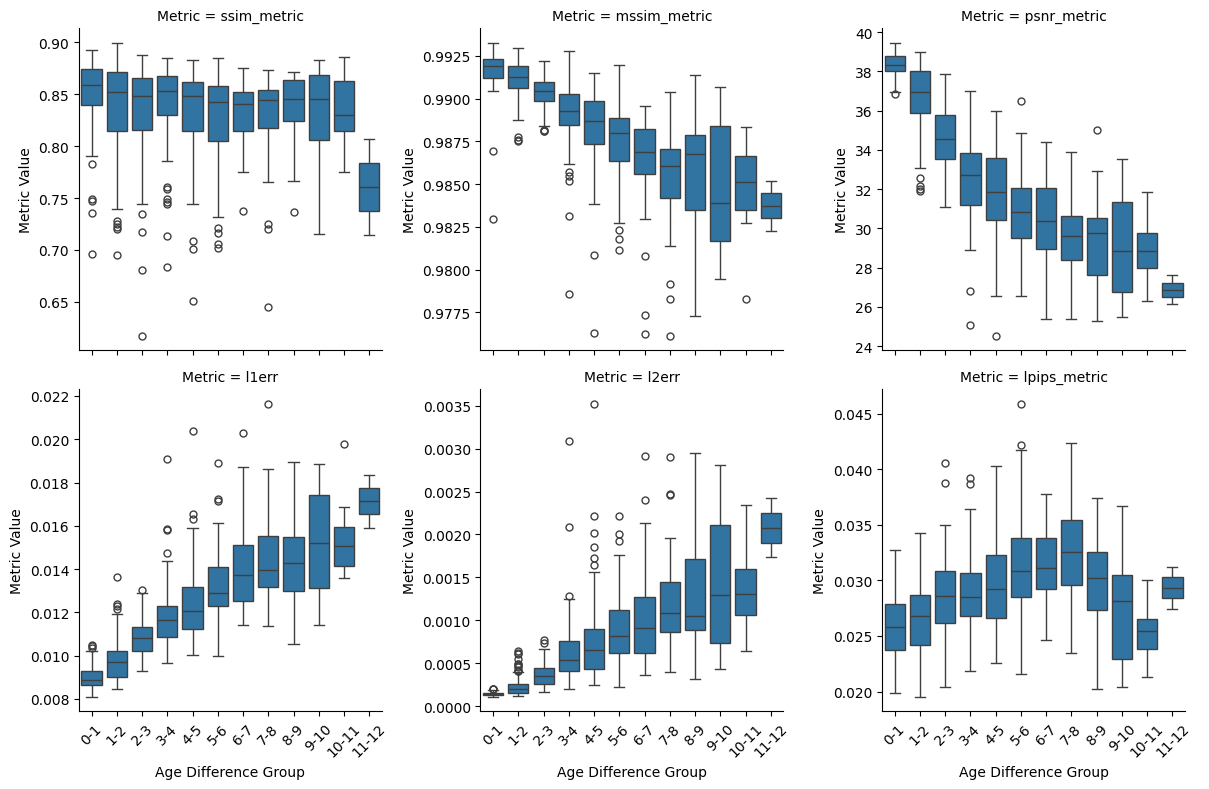

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt


# Melt dataframe to long format
df_long = df.melt(
    id_vars="diff_age_group", 
    value_vars=metric_keys, 
    var_name="Metric", 
    value_name="Value"
)

# Optional: order the age groups correctly
age_order = sorted(df['diff_age_group'].unique(), key=lambda x: int(x.split('-')[0]))

# Create FacetGrid boxplots
g = sns.catplot(
    data=df_long, 
    x="diff_age_group", 
    y="Value", 
    col="Metric", 
    kind="box", 
    col_wrap=3, 
    sharey=False,
    # sharex=False,   
    order=age_order,
    height=4,
    aspect=1
)

# Rotate x-axis labels for each subplot
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel("Age Difference Group")  # Set x-label
    ax.set_ylabel("Metric Value")          # Set y-label
    ax.grid(False)

plt.tight_layout()
plt.show()


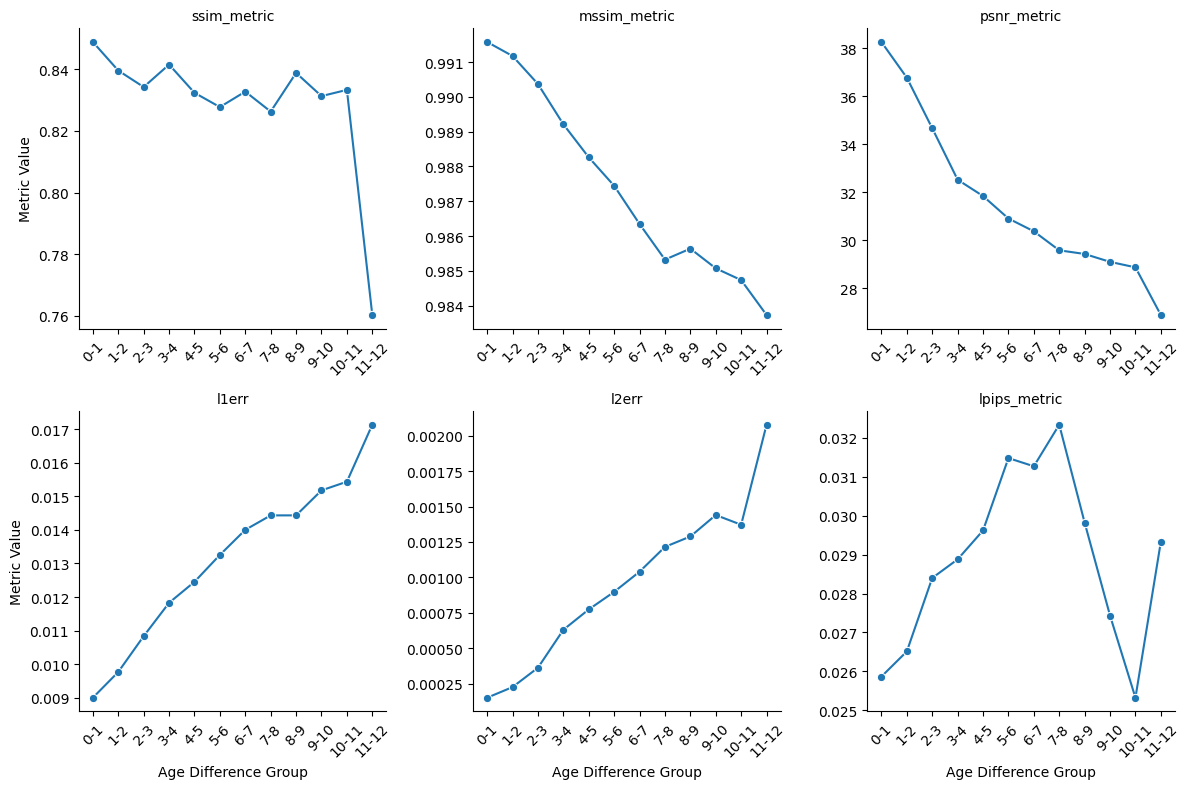

In [17]:

# Assume df_mean has age_group as index
df_mean_reset = df_mean.reset_index()  # reset index for seaborn

# Melt DataFrame to long format
df_long = df_mean_reset.melt(id_vars="diff_age_group", value_vars=metric_keys,
                             var_name="Metric", value_name="Value")

# Create FacetGrid
g = sns.FacetGrid(df_long, 
                  col="Metric", 
                  col_wrap=3, 
                  height=4, 
                  sharex=False, 
                  sharey=False)
g.map_dataframe(sns.lineplot, x="diff_age_group", y="Value", marker="o")
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Age Difference Group", "Metric Value")
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=45)
    ax.grid(False)

plt.tight_layout()
plt.show()


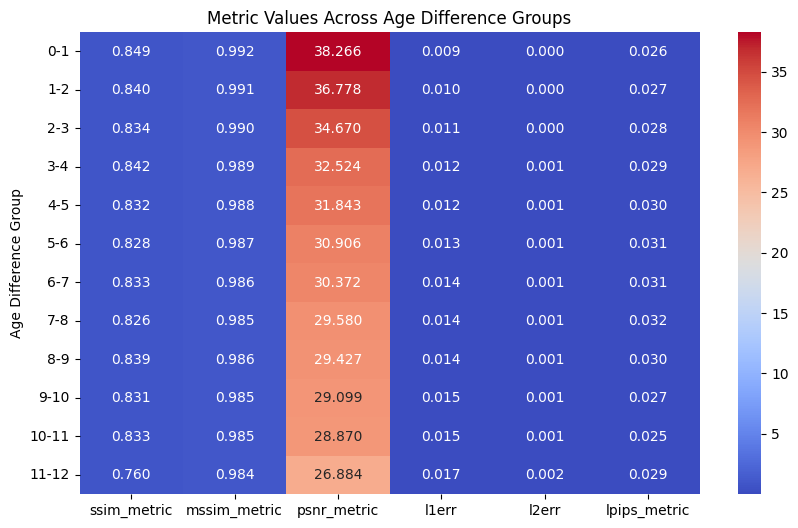

In [18]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(df_mean[metric_keys], annot=True, fmt=".3f", cmap="coolwarm")
plt.title("Metric Values Across Age Difference Groups")
plt.ylabel("Age Difference Group")
plt.show()
